# ⚙️ Configuration Guide

**Before running this notebook, review and adjust the settings below based on your environment.**

## Quick Setup

| Setting | Google Colab | Local Machine |
|---------|--------------|---------------|
| `USE_COLAB` | `True` | `False` |
| `USE_WANDB` | `True` (recommended) | `True` (recommended) |

## Environment Options

### 1. Execution Environment
- **Google Colab (Recommended)**: Click the "Open in Colab" badge, set `USE_COLAB = True`
- **Local Machine**: Clone repo, install requirements, set `USE_COLAB = False`

### 2. Experiment Tracking (Weights & Biases)
- **Enable**: Set `USE_WANDB = True`, add API key to Colab Secrets as `WANDB_API_KEY`
- **Disable**: Set `USE_WANDB = False` (no tracking)

### 3. GPU
- **Colab**: Runtime → Change runtime type → GPU (T4)
- **Local**: Requires NVIDIA GPU with CUDA

---
**Run the configuration cell below, then proceed with the notebook.**

# Block 1: Environment Setup

Initializes the runtime environment.

**Steps:**
```
├── Install dependencies (medmnist, wandb)
├── Import libraries
├── Configure W&B tracking (if enabled)
├── Set random seeds for reproducibility
└── Check GPU availability
```

**Key Configuration Variables:**
| Variable | Purpose |
|----------|---------|
| `USE_COLAB` | Enable Colab-specific features |
| `USE_WANDB` | Enable experiment tracking |
| `SEED` | Random seed (42) for reproducibility |
| `PROJECT_NAME` | W&B project name |

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

USE_COLAB = True          # True = Google Colab, False = Local
USE_WANDB = True          # True = Enable W&B tracking
SEED = 42                 # Random seed for reproducibility
PROJECT_NAME = 'DermaMNIST_Binary_Study'

# ============================================================================
# INSTALLATION
# ============================================================================

!pip install -q medmnist wandb

# ============================================================================
# IMPORTS
# ============================================================================

import os
import random
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, backend as K
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from medmnist import DermaMNIST

# ============================================================================
# WEIGHTS & BIASES
# ============================================================================

if USE_WANDB:
    import wandb
    from wandb.integration.keras import WandbMetricsLogger

    if USE_COLAB:
        from google.colab import userdata
        wandb.login(key=userdata.get('WANDB_API_KEY'))

    print("✅ W&B enabled")
else:
    wandb = None
    print("ℹ️ W&B disabled")

# ============================================================================
# REPRODUCIBILITY
# ============================================================================

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# ============================================================================
# GPU CHECK
# ============================================================================

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("⚠️ No GPU - training will be slow!")

print(f"✅ TensorFlow {tf.__version__}")
print(f"✅ Seed: {SEED}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abraham-gezehei (abraham-gezehei-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ W&B enabled
✅ GPU: /physical_device:GPU:0
✅ TensorFlow 2.19.0
✅ Seed: 42


# Block 2: Data Loading & Exploratory Data Analysis

Loads DermaMNIST dataset and transforms 7-class labels to binary classification.

**Steps:**
```
├── 2a: Explore raw data (7 original classes, pixel distributions)
├── 2b: Transform to binary classification (Malignant vs Benign)
└── 2c: Verify transformed data and compute class weights
```

**Dataset:** DermaMNIST (10,015 dermatoscopic images, 28×28×3 RGB)

**Binary Mapping:**
| Original Class | Code | Binary Label |
|----------------|------|--------------|
| Actinic keratoses (akiec) | 0 | Malignant (1) |
| Basal cell carcinoma (bcc) | 1 | Malignant (1) |
| Melanoma (mel) | 4 | Malignant (1) |
| Benign keratosis (bkl) | 2 | Benign (0) |
| Dermatofibroma (df) | 3 | Benign (0) |
| Melanocytic nevi (nv) | 5 | Benign (0) |
| Vascular lesions (vasc) | 6 | Benign (0) |

📊 EXPLORATORY DATA ANALYSIS - RAW DATA

1️⃣ DATASET OVERVIEW
----------------------------------------
   Training samples:   7,007
   Validation samples: 1,003
   Test samples:       2,005
   Total samples:      10,015

2️⃣ IMAGE PROPERTIES
----------------------------------------
   Shape: (28, 28, 3)
   Dtype: uint8
   Pixel range: [0, 255]

3️⃣ ORIGINAL LABEL DISTRIBUTION (7 Classes)
----------------------------------------
   Class                                 Count  Percent
   ----------------------------------- ------- --------
   Actinic keratoses (akiec)               228     3.3%
   Basal cell carcinoma (bcc)              359     5.1%
   Benign keratosis (bkl)                  769    11.0%
   Dermatofibroma (df)                      80     1.1%
   Melanoma (mel)                          779    11.1%
   Melanocytic nevi (nv)                 4,693    67.0%
   Vascular lesions (vasc)                  99     1.4%


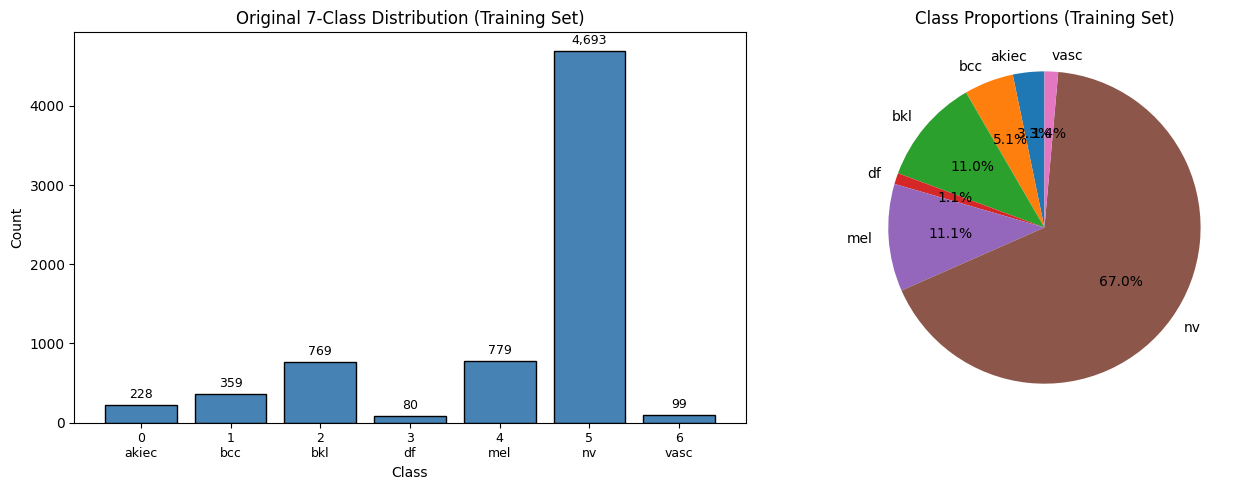


4️⃣ SAMPLE IMAGES FROM EACH CLASS
----------------------------------------


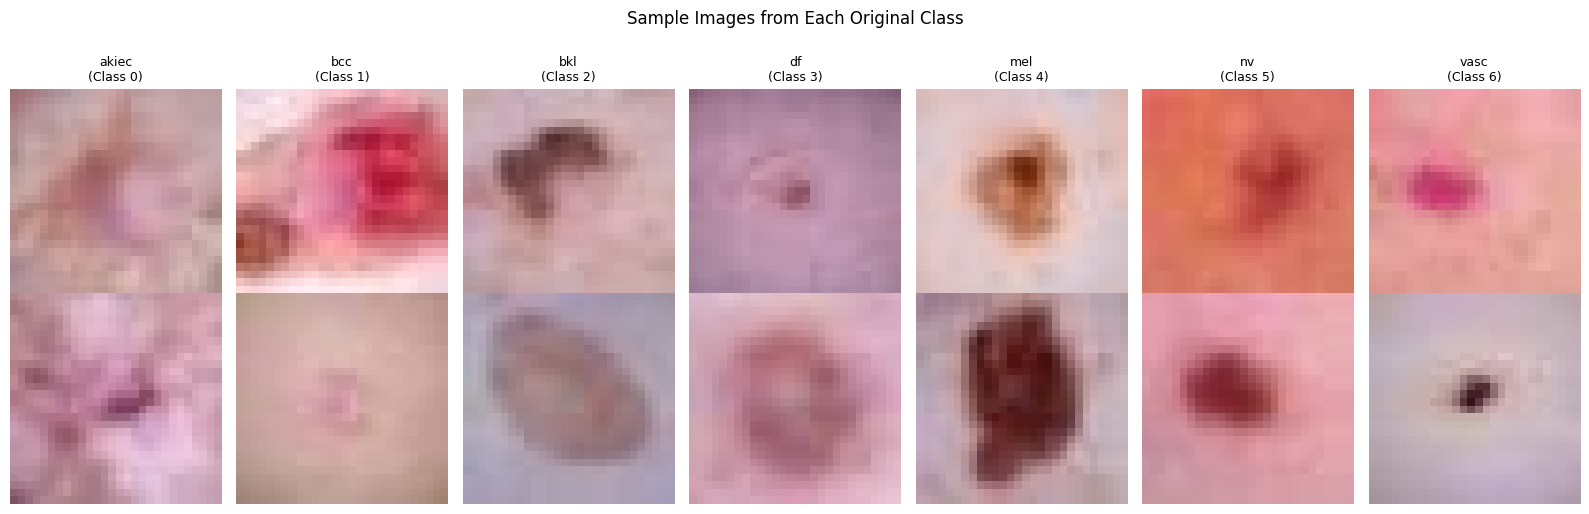


5️⃣ BINARY MAPPING PREVIEW
----------------------------------------
   Malignant (1): Classes 0, 1, 4
      - 0: Actinic keratoses (akiec)   → Pre-cancerous
      - 1: Basal cell carcinoma (bcc)  → Skin cancer
      - 4: Melanoma (mel)              → Skin cancer (most dangerous)

   Benign (0): Classes 2, 3, 5, 6
      - 2: Benign keratosis (bkl)      → Benign growth
      - 3: Dermatofibroma (df)         → Benign fibrous nodule
      - 5: Melanocytic nevi (nv)       → Benign moles
      - 6: Vascular lesions (vasc)     → Benign vascular

   Expected after transformation:
      Benign:    5,641 (80.5%)
      Malignant: 1,366 (19.5%)
      Ratio:     4.1:1 (Benign:Malignant)


In [3]:
# ============================================================================
# BLOCK 2a: EDA - RAW DATA EXPLORATION
# ============================================================================

print("="*60)
print("📊 EXPLORATORY DATA ANALYSIS - RAW DATA")
print("="*60)

raw_train = DermaMNIST(split='train', download=True, size=28)
raw_val = DermaMNIST(split='val', download=True, size=28)
raw_test = DermaMNIST(split='test', download=True, size=28)

print("\n1️⃣ DATASET OVERVIEW")
print("-"*40)
print(f"   Training samples:   {len(raw_train.imgs):,}")
print(f"   Validation samples: {len(raw_val.imgs):,}")
print(f"   Test samples:       {len(raw_test.imgs):,}")
print(f"   Total samples:      {len(raw_train.imgs) + len(raw_val.imgs) + len(raw_test.imgs):,}")

print("\n2️⃣ IMAGE PROPERTIES")
print("-"*40)
print(f"   Shape: {raw_train.imgs[0].shape}")
print(f"   Dtype: {raw_train.imgs[0].dtype}")
print(f"   Pixel range: [{raw_train.imgs.min()}, {raw_train.imgs.max()}]")

print("\n3️⃣ ORIGINAL LABEL DISTRIBUTION (7 Classes)")
print("-"*40)

class_names = {
    0: 'Actinic keratoses (akiec)',      # Pre-cancerous
    1: 'Basal cell carcinoma (bcc)',     # MALIGNANT - skin cancer
    2: 'Benign keratosis (bkl)',         # Benign
    3: 'Dermatofibroma (df)',            # Benign
    4: 'Melanoma (mel)',                 # MALIGNANT - most dangerous skin cancer
    5: 'Melanocytic nevi (nv)',          # Benign (common moles)
    6: 'Vascular lesions (vasc)'         # Benign
}

# Count each class
train_labels = raw_train.labels.flatten()
unique, counts = np.unique(train_labels, return_counts=True)

print(f"   {'Class':<35} {'Count':>7} {'Percent':>8}")
print(f"   {'-'*35} {'-'*7} {'-'*8}")
for cls, count in zip(unique, counts):
    pct = 100 * count / len(train_labels)
    print(f"   {class_names[cls]:<35} {count:>7,} {pct:>7.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
bars = ax1.bar(range(len(unique)), counts, color='steelblue', edgecolor='black')
ax1.set_xticks(range(len(unique)))
ax1.set_xticklabels([f"{i}\n{class_names[i].split('(')[1].replace(')', '')}" for i in unique], fontsize=9)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Original 7-Class Distribution (Training Set)')

# Add count labels on bars
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Pie chart
ax2 = axes[1]
ax2.pie(counts, labels=[class_names[i].split('(')[1].replace(')', '') for i in unique],
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Class Proportions (Training Set)')

plt.tight_layout()
plt.show()

print("\n4️⃣ SAMPLE IMAGES FROM EACH CLASS")
print("-"*40)

fig, axes = plt.subplots(2, 7, figsize=(16, 5))

for cls in range(7):
    cls_indices = np.where(train_labels == cls)[0]

    for row in range(2):
        idx = cls_indices[row]
        axes[row, cls].imshow(raw_train.imgs[idx])
        axes[row, cls].axis('off')
        if row == 0:
            short_name = class_names[cls].split('(')[1].replace(')', '')
            axes[row, cls].set_title(f'{short_name}\n(Class {cls})', fontsize=9)

plt.suptitle('Sample Images from Each Original Class', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print("\n5️⃣ BINARY MAPPING PREVIEW")
print("-"*40)
print("   Malignant (1): Classes 0, 1, 4")
print("      - 0: Actinic keratoses (akiec)   → Pre-cancerous")
print("      - 1: Basal cell carcinoma (bcc)  → Skin cancer")
print("      - 4: Melanoma (mel)              → Skin cancer (most dangerous)")
print("\n   Benign (0): Classes 2, 3, 5, 6")
print("      - 2: Benign keratosis (bkl)      → Benign growth")
print("      - 3: Dermatofibroma (df)         → Benign fibrous nodule")
print("      - 5: Melanocytic nevi (nv)       → Benign moles")
print("      - 6: Vascular lesions (vasc)     → Benign vascular")

# Calculate expected binary distribution
malignant_classes = [0, 1, 4]  # akiec, bcc, mel - CORRECTED!
malignant_count = sum(counts[i] for i in range(len(unique)) if unique[i] in malignant_classes)
benign_count = sum(counts[i] for i in range(len(unique)) if unique[i] not in malignant_classes)

print(f"\n   Expected after transformation:")
print(f"      Benign:    {benign_count:,} ({100*benign_count/len(train_labels):.1f}%)")
print(f"      Malignant: {malignant_count:,} ({100*malignant_count/len(train_labels):.1f}%)")
print(f"      Ratio:     {benign_count/malignant_count:.1f}:1 (Benign:Malignant)")

🔄 DATA TRANSFORMATION - BINARY CLASSIFICATION

1️⃣ LOADING DATASETS...
2️⃣ NORMALIZING IMAGES (0-255 → 0-1)...
3️⃣ TRANSFORMING LABELS TO BINARY...

4️⃣ BINARY CLASS DISTRIBUTION
----------------------------------------
   Train: Benign=5,641 (80.5%)  Malignant=1,366 (19.5%)
   Val  : Benign=807 (80.5%)  Malignant=196 (19.5%)
   Test : Benign=1,613 (80.4%)  Malignant=392 (19.6%)

   Class Imbalance Ratio: 4.13:1 (Benign:Malignant)


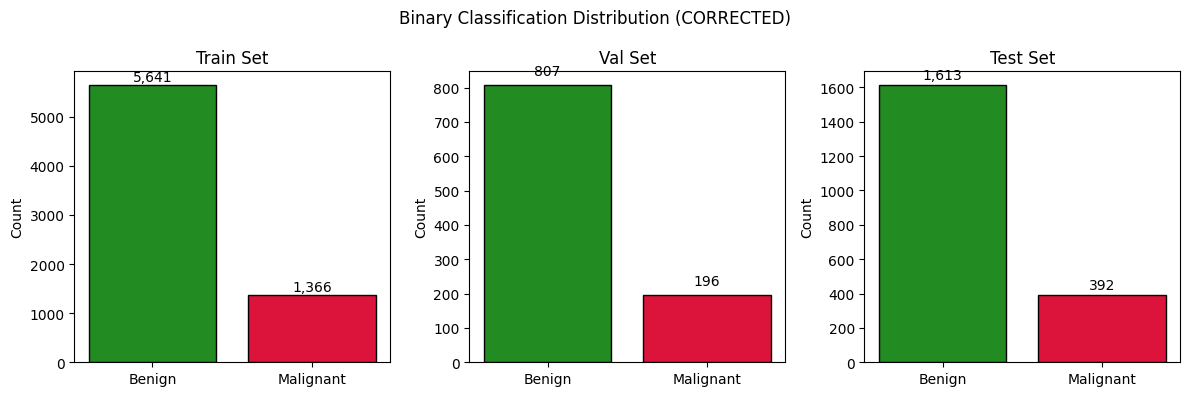


5️⃣ DATA SHAPES
----------------------------------------
   x_train: (7007, 28, 28, 3)  y_train: (7007, 2)  y_train_bin: (7007,)
   x_val:   (1003, 28, 28, 3)  y_val:   (1003, 2)  y_val_bin:   (1003,)
   x_test:  (2005, 28, 28, 3)  y_test:  (2005, 2)  y_test_bin:  (2005,)

6️⃣ DATA AUGMENTATION
----------------------------------------
   ✅ ImageDataGenerator configured
   Augmentations: rotation, shift, shear, zoom, flip

✅ DATA TRANSFORMATION COMPLETE (CORRECTED LABELS)

   Binary Classes:
   ├── 0 = Benign    (bkl, df, nv, vasc)
   └── 1 = Malignant (akiec, bcc, mel)

   Class Imbalance: 4.1:1
   → Recommend using class weights (W3 or W5)

   Data Dictionary Keys:
   ├── x_train, x_val, x_test     (images)
   ├── y_train, y_val, y_test     (one-hot labels)
   └── y_train_bin, y_val_bin, y_test_bin (binary labels)



In [4]:
# ============================================================================
# BLOCK 2b: DATA TRANSFORMATION - BINARY CLASSIFICATION
# ============================================================================

print("="*60)
print("🔄 DATA TRANSFORMATION - BINARY CLASSIFICATION")
print("="*60)

def transform_to_binary(labels):
    """
    Transform 7-class labels to binary (Benign=0, Malignant=1).

    CORRECTED MAPPING:
    - Malignant (1): akiec (0), bcc (1), mel (4)
    - Benign (0): bkl (2), df (3), nv (5), vasc (6)

    Args:
        labels: Original 7-class labels (0-6)

    Returns:
        Binary labels (0=Benign, 1=Malignant)
    """
    malignant_classes = [0, 1, 4]  # akiec, bcc, mel - CORRECTED!
    binary_labels = np.isin(labels.flatten(), malignant_classes).astype(int)
    return binary_labels

print("\n1️⃣ LOADING DATASETS...")
train_dataset = DermaMNIST(split='train', download=True, size=28)
val_dataset = DermaMNIST(split='val', download=True, size=28)
test_dataset = DermaMNIST(split='test', download=True, size=28)

# Extract and normalize images
print("2️⃣ NORMALIZING IMAGES (0-255 → 0-1)...")
x_train = train_dataset.imgs.astype(np.float32) / 255.0
x_val = val_dataset.imgs.astype(np.float32) / 255.0
x_test = test_dataset.imgs.astype(np.float32) / 255.0

# Transform labels to binary
print("3️⃣ TRANSFORMING LABELS TO BINARY...")
y_train_binary = transform_to_binary(train_dataset.labels)
y_val_binary = transform_to_binary(val_dataset.labels)
y_test_binary = transform_to_binary(test_dataset.labels)

# One-hot encode
y_train = tf.keras.utils.to_categorical(y_train_binary, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val_binary, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test_binary, num_classes=2)

# Verify binary distribution
print("\n4️⃣ BINARY CLASS DISTRIBUTION")
print("-"*40)

for name, labels in [('Train', y_train_binary), ('Val', y_val_binary), ('Test', y_test_binary)]:
    benign = np.sum(labels == 0)
    malignant = np.sum(labels == 1)
    total = len(labels)
    print(f"   {name:5}: Benign={benign:,} ({100*benign/total:.1f}%)  Malignant={malignant:,} ({100*malignant/total:.1f}%)")

# Calculate class imbalance ratio
train_benign = np.sum(y_train_binary == 0)
train_malignant = np.sum(y_train_binary == 1)
imbalance_ratio = train_benign / train_malignant

print(f"\n   Class Imbalance Ratio: {imbalance_ratio:.2f}:1 (Benign:Malignant)")

# Visualize binary distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (name, labels) in zip(axes, [('Train', y_train_binary), ('Val', y_val_binary), ('Test', y_test_binary)]):
    benign = np.sum(labels == 0)
    malignant = np.sum(labels == 1)

    bars = ax.bar(['Benign', 'Malignant'], [benign, malignant],
                  color=['forestgreen', 'crimson'], edgecolor='black')
    ax.set_title(f'{name} Set')
    ax.set_ylabel('Count')

    # Add count labels
    for bar, count in zip(bars, [benign, malignant]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Binary Classification Distribution (CORRECTED)', fontsize=12)
plt.tight_layout()
plt.show()

data = {
    'x_train': x_train,
    'y_train': y_train,              # One-hot encoded [1,0] or [0,1]
    'y_train_bin': y_train_binary,   # Binary: 0 or 1
    'x_val': x_val,
    'y_val': y_val,                  # One-hot encoded
    'y_val_bin': y_val_binary,       # Binary: 0 or 1
    'x_test': x_test,
    'y_test': y_test,                # One-hot encoded
    'y_test_bin': y_test_binary,     # Binary: 0 or 1
    'class_weights': None            # Will be set in Block 6
}

print("\n5️⃣ DATA SHAPES")
print("-"*40)
print(f"   x_train: {x_train.shape}  y_train: {y_train.shape}  y_train_bin: {y_train_binary.shape}")
print(f"   x_val:   {x_val.shape}  y_val:   {y_val.shape}  y_val_bin:   {y_val_binary.shape}")
print(f"   x_test:  {x_test.shape}  y_test:  {y_test.shape}  y_test_bin:  {y_test_binary.shape}")

# Data augmentation
print("\n6️⃣ DATA AUGMENTATION")
print("-"*40)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

print("   ✅ ImageDataGenerator configured")
print("   Augmentations: rotation, shift, shear, zoom, flip")

print("\n" + "="*60)
print("✅ DATA TRANSFORMATION COMPLETE (CORRECTED LABELS)")
print("="*60)
print(f"""
   Binary Classes:
   ├── 0 = Benign    (bkl, df, nv, vasc)
   └── 1 = Malignant (akiec, bcc, mel)

   Class Imbalance: {imbalance_ratio:.1f}:1
   → Recommend using class weights (W3 or W5)

   Data Dictionary Keys:
   ├── x_train, x_val, x_test     (images)
   ├── y_train, y_val, y_test     (one-hot labels)
   └── y_train_bin, y_val_bin, y_test_bin (binary labels)
""")


📊 EXPLORATORY DATA ANALYSIS - TRANSFORMED DATA

1️⃣ TRANSFORMED DATA OVERVIEW
----------------------------------------
   Split        Shape                Dtype        Pixel Range
   ------------ -------------------- ------------ ---------------
   Train        (7007, 28, 28, 3)    float32      [0.00, 1.00]
   Val          (1003, 28, 28, 3)    float32      [0.00, 1.00]
   Test         (2005, 28, 28, 3)    float32      [0.00, 1.00]

2️⃣ BINARY LABEL DISTRIBUTION
----------------------------------------
   Train:
      Benign (0):    5,641 ( 80.5%)
      Malignant (1): 1,366 ( 19.5%)
      Ratio: 4.1:1

   Val:
      Benign (0):      807 ( 80.5%)
      Malignant (1):   196 ( 19.5%)
      Ratio: 4.1:1

   Test:
      Benign (0):    1,613 ( 80.4%)
      Malignant (1):   392 ( 19.6%)
      Ratio: 4.1:1



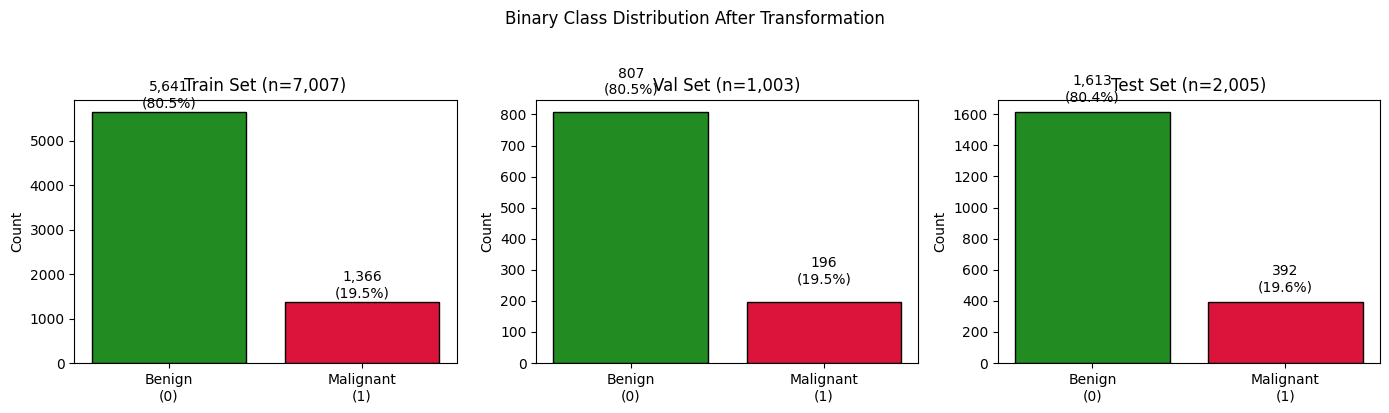


3️⃣ SAMPLE IMAGES BY BINARY CLASS
----------------------------------------


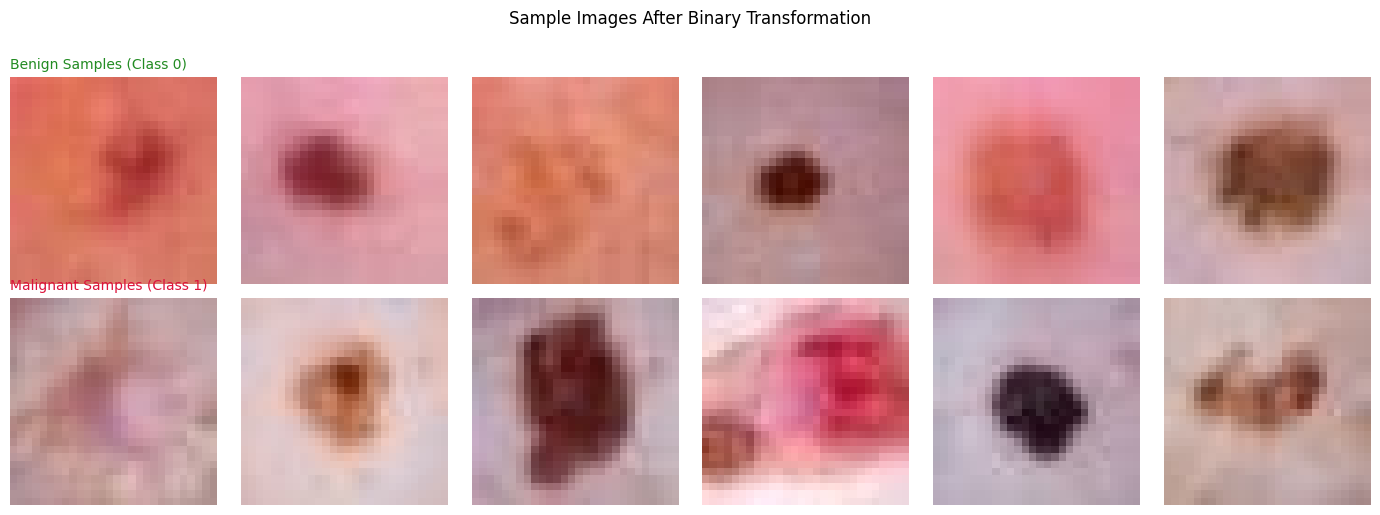


4️⃣ ONE-HOT ENCODING VERIFICATION
----------------------------------------
   y_train shape: (7007, 2)
   y_train sample (first 5):
   [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]

5️⃣ DATA AUGMENTATION PREVIEW
----------------------------------------


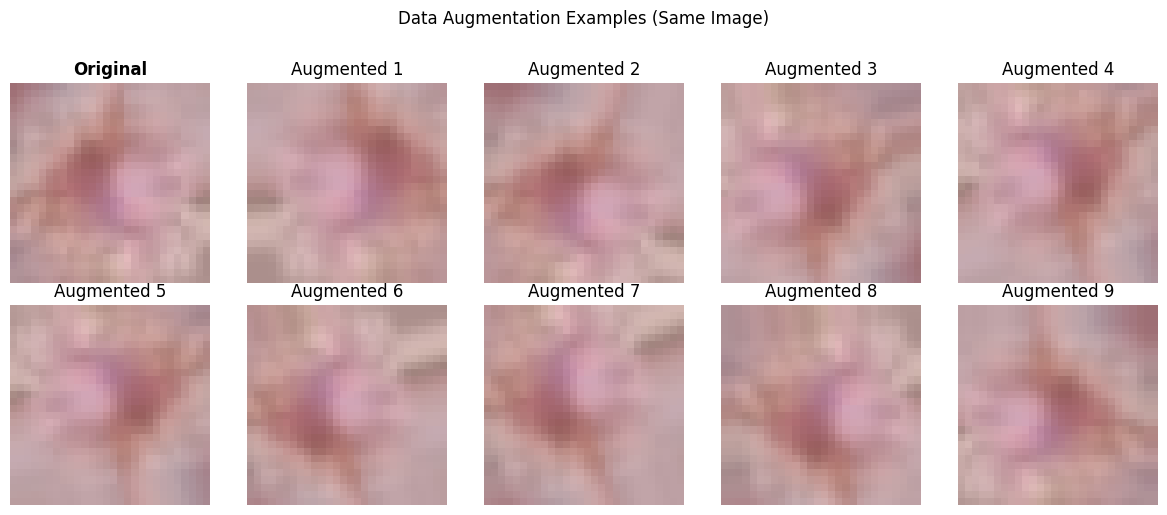


6️⃣ CLASS IMBALANCE SUMMARY
----------------------------------------
   ⚠️  Your data is IMBALANCED
   
   Benign:Malignant ratio = ~4:1
   
   Without intervention, model will likely:
      • Predict 'Benign' most of the time (81% accuracy!)
      • Have LOW recall for Malignant class
   
   Strategies to address:
      • Class weights

✅ EDA COMPLETE - Ready for modeling


In [5]:
# ============================================================================
# BLOCK 2c: EDA - TRANSFORMED DATA & DEFINE TRAIN, VAL & TEST DATA
# ============================================================================

print("\n" + "="*60)
print("📊 EXPLORATORY DATA ANALYSIS - TRANSFORMED DATA")
print("="*60)

print("\n1️⃣ TRANSFORMED DATA OVERVIEW")
print("-"*40)
print(f"   {'Split':<12} {'Shape':<20} {'Dtype':<12} {'Pixel Range'}")
print(f"   {'-'*12} {'-'*20} {'-'*12} {'-'*15}")
print(f"   {'Train':<12} {str(data['x_train'].shape):<20} {str(data['x_train'].dtype):<12} [{data['x_train'].min():.2f}, {data['x_train'].max():.2f}]")
print(f"   {'Val':<12} {str(data['x_val'].shape):<20} {str(data['x_val'].dtype):<12} [{data['x_val'].min():.2f}, {data['x_val'].max():.2f}]")
print(f"   {'Test':<12} {str(data['x_test'].shape):<20} {str(data['x_test'].dtype):<12} [{data['x_test'].min():.2f}, {data['x_test'].max():.2f}]")

print("\n2️⃣ BINARY LABEL DISTRIBUTION")
print("-"*40)

for split_name, y_bin in [('Train', data['y_train_bin']),
                           ('Val', data['y_val_bin']),
                           ('Test', data['y_test_bin'])]:
    total = len(y_bin)
    malignant = y_bin.sum()
    benign = total - malignant
    print(f"   {split_name}:")
    print(f"      Benign (0):    {benign:>5,} ({100*benign/total:>5.1f}%)")
    print(f"      Malignant (1): {int(malignant):>5,} ({100*malignant/total:>5.1f}%)")
    print(f"      Ratio: {benign/malignant:.1f}:1")
    print()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (split_name, y_bin) in zip(axes, [('Train', data['y_train_bin']),
                                           ('Val', data['y_val_bin']),
                                           ('Test', data['y_test_bin'])]):
    total = len(y_bin)
    malignant = int(y_bin.sum())
    benign = total - malignant

    bars = ax.bar(['Benign\n(0)', 'Malignant\n(1)'], [benign, malignant],
                  color=['forestgreen', 'crimson'], edgecolor='black')
    ax.set_title(f'{split_name} Set (n={total:,})')
    ax.set_ylabel('Count')

    # Add labels
    for bar, count in zip(bars, [benign, malignant]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count:,}\n({100*count/total:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.suptitle('Binary Class Distribution After Transformation', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print("\n3️⃣ SAMPLE IMAGES BY BINARY CLASS")
print("-"*40)

fig, axes = plt.subplots(2, 6, figsize=(14, 5))

y_train_flat = data['y_train_bin'].flatten()

for row, (cls, cls_name, color) in enumerate([(0, 'Benign', 'forestgreen'),
                                                (1, 'Malignant', 'crimson')]):
    cls_indices = np.where(y_train_flat == cls)[0]

    for col in range(6):
        idx = cls_indices[col]
        axes[row, col].imshow(data['x_train'][idx])
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(cls_name, fontsize=12, color=color, fontweight='bold')

axes[0, 0].set_title('Benign Samples (Class 0)', fontsize=10, loc='left', color='forestgreen')
axes[1, 0].set_title('Malignant Samples (Class 1)', fontsize=10, loc='left', color='crimson')

plt.suptitle('Sample Images After Binary Transformation', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print("\n4️⃣ ONE-HOT ENCODING VERIFICATION")
print("-"*40)
print(f"   y_train shape: {data['y_train'].shape}")
print(f"   y_train sample (first 5):")
print(f"   {data['y_train'][:5]}")

print("\n5️⃣ DATA AUGMENTATION PREVIEW")
print("-"*40)

# Pick one sample
sample_idx = np.where(data['y_train_bin'].flatten() == 1)[0][0]  # First malignant
sample_img = data['x_train'][sample_idx:sample_idx+1]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Original
axes[0, 0].imshow(sample_img[0])
axes[0, 0].set_title('Original', fontweight='bold')
axes[0, 0].axis('off')

# Augmented versions
aug_iter = datagen.flow(sample_img, batch_size=1, seed=SEED)
for i in range(1, 10):
    row = i // 5
    col = i % 5
    aug_img = next(aug_iter)[0]
    axes[row, col].imshow(aug_img)
    axes[row, col].set_title(f'Augmented {i}')
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples (Same Image)', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print("\n6️⃣ CLASS IMBALANCE SUMMARY")
print("-"*40)

# Calculate actual ratio from data
train_mal = data['y_train_bin'].sum()
train_ben = len(data['y_train_bin']) - train_mal
actual_ratio = train_ben / train_mal

print(f"   ⚠️  Your data is IMBALANCED")
print(f"   ")
print(f"   Benign:Malignant ratio = ~{actual_ratio:.0f}:1")
print(f"   ")
print(f"   Without intervention, model will likely:")
print(f"      • Predict 'Benign' most of the time ({100*train_ben/len(data['y_train_bin']):.0f}% accuracy!)")
print(f"      • Have LOW recall for Malignant class")
print(f"   ")
print(f"   Strategies to address:")
print(f"      • Class weights")

print("\n" + "="*60)
print("✅ EDA COMPLETE - Ready for modeling")
print("="*60)

# Block 3: Model Architectures

Defines all model architectures for Phase 1 screening.

**Architectures:**
| Function | Model | Parameters | Input |
|----------|-------|------------|-------|
| `build_custom_cnn()` | Custom CNN | ~50K-200K | 28×28 |
| `build_hybrid_cnn()` | Hybrid CNN + CBAM | ~80K-100K | 28×28 |
| `build_transfer_model()` | MobileNetV2 | 3.4M | 56×56 |
| `build_transfer_model()` | EfficientNetB0 | 5.3M | 56×56 |
| `build_transfer_model()` | DenseNet121 | 8M | 56×56 |

**Note:** Transfer models upsample 28×28 → 56×56 using bilinear interpolation.

In [6]:
# ============================================================================
# BLOCK 3: MODEL ARCHITECTURES
# ============================================================================

def build_custom_cnn(filters_base=32, depth=3, dropout=0.5, dense_units=256):
    """Optimized CNN baseline for 28x28 images."""
    model = models.Sequential([layers.Input(shape=(28, 28, 3))])

    for i in range(depth):
        filters = filters_base * (2 ** min(i, 2))

        model.add(layers.Conv2D(filters, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))

        model.add(layers.Conv2D(filters, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))

        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout * 0.5))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(2, activation='softmax'))

    return model

def channel_attention(input_tensor, ratio=8):
    """Channel Attention: focuses on 'what' is meaningful."""
    channels = input_tensor.shape[-1]

    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    avg_pool = layers.Reshape((1, 1, channels))(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    max_pool = layers.Reshape((1, 1, channels))(max_pool)

    shared_dense1 = layers.Dense(channels // ratio, activation='relu')
    shared_dense2 = layers.Dense(channels, activation='linear')

    avg_out = shared_dense2(shared_dense1(avg_pool))
    max_out = shared_dense2(shared_dense1(max_pool))

    attention = layers.Add()([avg_out, max_out])
    attention = layers.Activation('sigmoid')(attention)

    return layers.Multiply()([input_tensor, attention])

def spatial_attention(input_tensor, kernel_size=7):
    """Spatial Attention: focuses on 'where' is meaningful."""
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)

    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')(concat)

    return layers.Multiply()([input_tensor, attention])

def cbam_block(input_tensor, ratio=8, kernel_size=7):
    """CBAM: Convolutional Block Attention Module."""
    x = channel_attention(input_tensor, ratio)
    x = spatial_attention(x, kernel_size)
    return x

def build_hybrid_cnn(filters_base=64, depth=3, dropout=0.5, dense_units=256, use_cbam=True):
    """Hybrid CNN with optional CBAM Attention."""
    inputs = layers.Input(shape=(28, 28, 3))
    x = inputs

    x = layers.Conv2D(filters_base, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    for i in range(depth):
        filters = filters_base * (2 ** min(i, 2))

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        if use_cbam and x.shape[1] >= 7:
            x = cbam_block(x, ratio=8, kernel_size=3)

        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(dropout * 0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs, name="hybrid_cnn_cbam" if use_cbam else "hybrid_cnn")

def build_transfer_model(base_name='mobilenetv2', dropout=0.5, unfreeze_layers=None, dense_units=256):
    """Transfer Learning with lightweight pre-trained models."""
    inputs = layers.Input(shape=(28, 28, 3))

    # Upsample 28x28 → 56x56
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)

    base_models = {
        'mobilenetv2': lambda: MobileNetV2(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg'),
        'efficientnet': lambda: EfficientNetB0(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg'),
        'densenet': lambda: DenseNet121(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg')
    }

    base = base_models[base_name]()

    # Fine-tuning strategy
    if unfreeze_layers is None:
        base.trainable = True
    elif unfreeze_layers == 0:
        base.trainable = False
    else:
        base.trainable = True
        for layer in base.layers[:-unfreeze_layers]:
            layer.trainable = False

    x = base(x, training=False)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout * 0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs, name=f"{base_name}_model")

print("✅ Model architectures loaded")

✅ Model architectures loaded


# Block 4: Training Configuration & Helpers

Defines F2 Score metric, W&B logging, and model compilation.

**Components:**
| Component | Purpose |
|-----------|---------|
| `F2Score` | Custom metric (weights recall 2× over precision) |
| `WandbGroupedMetricsLogger` | Logs metrics grouped for W&B visualization |
| `compile_model()` | Compiles with Adam, crossentropy, and clinical metrics |

**Why F2 Score?**

$$F_2 = \frac{5 \times \text{Precision} \times \text{Recall}}{4 \times \text{Precision} + \text{Recall}}$$
```
├── Weights Recall 2× more than Precision
├── Prevents "all Malignant" predictions (low precision → low F2)
├── Prevents "all Benign" predictions (zero recall → F2 = 0)
└── Aligns with clinical priority: don't miss cancer!
```

In [19]:
# ============================================================================
# BLOCK 4: TRAINING CONFIGURATION
# ============================================================================

MONITOR_METRIC = 'val_f2_score'
MONITOR_MODE = 'max'

# ============================================================================
# F2 SCORE METRIC
# ============================================================================

class F2Score(tf.keras.metrics.Metric):
    """F2 Score: weights Recall 2x more than Precision."""

    def __init__(self, name='f2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)

        y_pred_classes = tf.cast(y_pred_classes, tf.float32)
        y_true_classes = tf.cast(y_true_classes, tf.float32)

        tp = tf.reduce_sum(y_true_classes * y_pred_classes)
        fp = tf.reduce_sum((1 - y_true_classes) * y_pred_classes)
        fn = tf.reduce_sum(y_true_classes * (1 - y_pred_classes))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f2 = 5 * (precision * recall) / (4 * precision + recall + tf.keras.backend.epsilon())
        return f2

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

# ============================================================================
# W&B METRICS LOGGER
# ============================================================================

class WandbGroupedMetricsLogger(tf.keras.callbacks.Callback):
    """Logs metrics grouped for W&B visualization."""

    def on_epoch_end(self, epoch, logs=None):
        if not USE_WANDB or wandb is None:
            return

        logs = logs or {}
        grouped_logs = {
            'epoch': epoch,
            'loss/train': logs.get('loss'),
            'loss/val': logs.get('val_loss'),
            'f2/train': logs.get('f2_score'),
            'f2/val': logs.get('val_f2_score'),
            'recall/train': logs.get('recall'),
            'recall/val': logs.get('val_recall'),
            'precision/train': logs.get('precision'),
            'precision/val': logs.get('val_precision'),
            'auc/train': logs.get('auc'),
            'auc/val': logs.get('val_auc'),
        }
        grouped_logs = {k: v for k, v in grouped_logs.items() if v is not None}
        wandb.log(grouped_logs)

# ============================================================================
# MODEL COMPILATION
# ============================================================================

def compile_model(model, learning_rate):
    """Compile model with clinical metrics including F2 Score."""
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(class_id=1, name='precision'),
            tf.keras.metrics.Recall(class_id=1, name='recall'),
            F2Score(name='f2_score')
        ]
    )

print(f"✅ Monitor metric: {MONITOR_METRIC} ({MONITOR_MODE})")

✅ Monitor metric: val_f2_score (max)


# Block 5: Main Training Loop

Orchestrates the complete training pipeline for any architecture.

**Function:** `train_experiment(config, data, datagen)`

**Pipeline:**
```
├── 1. Build model (based on config['architecture'])
├── 2. Compile with F2 metric
├── 3. Setup callbacks (EarlyStopping on val_f2)
├── 4. Prepare data generators
├── 5. Train model
├── 6. Evaluate best epoch
├── 7. Log to W&B (if enabled)
├── 8. Return results dictionary
└── 9. Cleanup (clear session, gc)
```

**Returns:** Dictionary with best metrics, confusion matrix values, and config.

In [15]:
# ============================================================================
# BLOCK 5: TRAINING LOOP
# ============================================================================

def train_experiment(config, data, datagen):
    """Train a single experiment with the given configuration."""

    print(f"\n{'='*60}\n🚀 STARTING: {config['name']}\n{'='*60}")

    # ────────────────────────────────────────────────────────────────
    # 1. BUILD MODEL
    # ────────────────────────────────────────────────────────────────
    arch = config['architecture']

    if arch == 'custom_cnn':
        model = build_custom_cnn(
            filters_base=config.get('filters_base', 32),
            depth=config.get('depth', 3),
            dropout=config.get('dropout', 0.5),
            dense_units=config.get('dense_units', 512)
        )
    elif arch == 'hybrid_cnn':
        model = build_hybrid_cnn(
            filters_base=config.get('filters_base', 64),
            depth=config.get('depth', 4),
            dropout=config.get('dropout', 0.5),
            dense_units=config.get('dense_units', 256),
            use_cbam=config.get('use_cbam', True)
        )
    elif arch == 'transfer':
        model = build_transfer_model(
            base_name=config.get('base_name', 'mobilenetv2'),
            dropout=config.get('dropout', 0.5),
            unfreeze_layers=config.get('unfreeze_layers', None),
            dense_units=config.get('dense_units', 256)
        )
    else:
        raise ValueError(f"Unknown architecture: {arch}")

    # ────────────────────────────────────────────────────────────────
    # 2. COMPILE MODEL
    # ────────────────────────────────────────────────────────────────
    compile_model(model, learning_rate=config.get('learning_rate', 0.001))

    # ────────────────────────────────────────────────────────────────
    # 3. SETUP CALLBACKS
    # ────────────────────────────────────────────────────────────────
    callback_list = [
        callbacks.EarlyStopping(
            monitor=MONITOR_METRIC,
            patience=config.get('patience', 10),
            mode=MONITOR_MODE,
            restore_best_weights=True,
            verbose=1
        )
    ]

    if USE_WANDB and wandb is not None:
        wandb.init(
            project=PROJECT_NAME,
            name=config['name'],
            config=config,
            reinit=True
        )
        callback_list.append(WandbGroupedMetricsLogger())

    # ────────────────────────────────────────────────────────────────
    # 4. PREPARE DATA
    # ────────────────────────────────────────────────────────────────
    batch_size = config.get('batch_size', 64)

    train_generator = datagen.flow(
        data['x_train'], data['y_train'],
        batch_size=batch_size,
        shuffle=True
    )
    val_data = (data['x_val'], data['y_val'])

    # ────────────────────────────────────────────────────────────────
    # 5. TRAIN MODEL
    # ────────────────────────────────────────────────────────────────
    history = model.fit(
        train_generator,
        epochs=config.get('epochs', 50),
        validation_data=val_data,
        class_weight=data['class_weights'],
        callbacks=callback_list,
        verbose=1
    )

    # ────────────────────────────────────────────────────────────────
    # 6. EVALUATE BEST MODEL
    # ────────────────────────────────────────────────────────────────
    val_f2_history = history.history['val_f2_score']
    best_epoch_idx = np.argmax(val_f2_history)

    best_val_f2 = val_f2_history[best_epoch_idx]
    best_val_recall = history.history['val_recall'][best_epoch_idx]
    best_val_precision = history.history['val_precision'][best_epoch_idx]
    best_val_auc = history.history['val_auc'][best_epoch_idx]

    y_pred_proba = model.predict(data['x_val'], verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(data['y_val'], axis=1)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision_cm = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_cm = tp / (tp + fn) if (tp + fn) > 0 else 0
    f2_cm = 5 * (precision_cm * recall_cm) / (4 * precision_cm + recall_cm) if (4 * precision_cm + recall_cm) > 0 else 0

    print(f"""
   Confusion Matrix:
                    Predicted
                  Benign  Malignant
   Actual Benign   (TN) {tn:4d}   (FP) {fp:4d}
          Malig.   (FN) {fn:4d}   (TP) {tp:4d}

   ❌ Missed Cancers (FN): {fn}
   ⚠️  False Alarms (FP):  {fp}""")

    # ────────────────────────────────────────────────────────────────
    # 7. LOG TO W&B
    # ────────────────────────────────────────────────────────────────
    if USE_WANDB and wandb is not None:
        wandb.summary['best_val_f2'] = best_val_f2
        wandb.summary['best_val_recall'] = best_val_recall
        wandb.summary['best_val_precision'] = best_val_precision
        wandb.summary['best_val_auc'] = best_val_auc
        wandb.summary['best_epoch'] = best_epoch_idx + 1
        wandb.summary['cm_tn'] = tn
        wandb.summary['cm_fp'] = fp
        wandb.summary['cm_fn'] = fn
        wandb.summary['cm_tp'] = tp

        wandb.log({
            'conf_mat': wandb.plot.confusion_matrix(
                y_true=y_true,
                preds=y_pred,
                class_names=['Benign', 'Malignant']
            )
        })

        wandb.finish()

    # ────────────────────────────────────────────────────────────────
    # 8. RETURN RESULTS
    # ────────────────────────────────────────────────────────────────
    results = {
        'name': config['name'],
        'architecture': arch,
        'best_epoch': best_epoch_idx + 1,
        'best_val_f2': best_val_f2,
        'best_val_recall': best_val_recall,
        'best_val_precision': best_val_precision,
        'best_val_auc': best_val_auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'config': config
    }

    print(f"\n✅ {config['name']} complete (Best Epoch: {best_epoch_idx + 1})")

    # ────────────────────────────────────────────────────────────────
    # 9. CLEANUP
    # ────────────────────────────────────────────────────────────────
    K.clear_session()
    gc.collect()

    return results

print("✅ Training loop loaded")

✅ Training loop loaded


# Block 6: Phase 1 — Architecture Screening

## Goal
Find the best **architecture + fine-tuning strategy** combination for malignant lesion detection.

## Experimental Design (14 runs)

| Architecture   | Variants                                                 | Runs | Parameters |
|----------------|----------------------------------------------------------|------|------------|
| Custom CNN     | shallow (d=3, f=32), deep (d=4, f=64), wide (d=3, f=128) | 3    | ~50K-200K  |
| Hybrid CNN     | with CBAM, without CBAM                                  | 2    | ~80K-100K  |
| MobileNetV2    | frozen, partial (50 layers), full                        | 3    | 3.4M       |
| EfficientNetB0 | frozen, partial (100 layers), full                       | 3    | 5.3M       |
| DenseNet121    | frozen, partial (50 layers), full                        | 3    | 8M         |
| **Total**      |                                                          | **14** |          |

## Fixed Parameters

All experiments use **W3** class weighting: `{0: 1.0, 1: 3.0}` — penalizes missed malignant cases 3× more than false alarms.

## Selection Criterion

Best model selected by **validation F2 score** (weights recall 2× over precision).

In [9]:
#============================================================================
# BLOCK 6: Phase 1 — Architecture Screening
# ============================================================================

WEIGHT_TAG = "W3"
data['class_weights'] = {0: 1.0, 1: 3.0}

print(f"✅ Class weights set: {data['class_weights']}")

phase1_results = []

✅ Class weights set: {0: 1.0, 1: 3.0}


# Block 6a: Custom CNN (3 runs)

Tests three CNN configurations varying depth and width to find optimal complexity for 28×28 images.

| Name | Depth | Filters | Hypothesis |
|------|-------|---------|------------|
| P1_CNN_shallow | 3 | 32 | Simple may be sufficient |
| P1_CNN_deep | 4 | 64 | More depth = more features |
| P1_CNN_wide | 3 | 128 | More filters = more capacity |

**Why Custom CNN?**
- Native 28×28 input (no upsampling artifacts like transfer learning)
- Appropriate complexity for ~7K training samples (avoids overfitting)
- Fast training and inference

In [14]:
# ============================================================================
# 6a: CUSTOM CNN (3 runs)
# ============================================================================

print(f"✅ Running Custom CNN experiments (3 runs)")

configs_cnn = [
    {
        # Shallow: Tests if simple architecture suffices for low-resolution images
        'name': f'P1_CNN_shallow_{WEIGHT_TAG}',
        'architecture': 'custom_cnn',
        'filters_base': 32,
        'depth': 3,
        'dropout': 0.4,
        'dense_units': 128,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 10,
    },
    {
        # Deep: Tests if additional layers capture more discriminative features
        'name': f'P1_CNN_deep_{WEIGHT_TAG}',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.4,
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 10,
    },
    {
        # Wide: Tests if more filters per layer improve feature extraction
        'name': f'P1_CNN_wide_{WEIGHT_TAG}',
        'architecture': 'custom_cnn',
        'filters_base': 128,
        'depth': 3,
        'dropout': 0.5,
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 10,
    },
]

for config in configs_cnn:
    result = train_experiment(config, data, datagen)
    phase1_results.append(result)

✅ Running Custom CNN experiments (3 runs)

🚀 STARTING: P1_CNN_shallow_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - auc: 0.6097 - f2_score: 0.5240 - loss: 1.1235 - precision: 0.2648 - recall: 0.6944 - val_auc: 0.1930 - val_f2_score: 0.5484 - val_loss: 0.7063 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.7333 - f2_score: 0.6111 - loss: 0.8472 - precision: 0.3406 - recall: 0.7636 - val_auc: 0.1754 - val_f2_score: 0.5484 - val_loss: 0.7496 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.7873 - f2_score: 0.6173 - loss: 0.7747 - precision: 0.3685 - recall: 0.7431 - val_auc: 0.1888 - val_f2_score: 0.5459 - val_loss: 0.8086 - val_precision: 0.1946 - val_recall: 0.9949
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - auc: 0.8257 - f2_score: 0.6302 - loss: 0.7055 - precision: 0.3982 - recall: 0.7380 - val_auc: 0.2364 - val_f2_score: 0.5484 - val_loss: 1.1038 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms

auc/train,▁▄▅▆▆▇▇▇▇▇█████████
auc/val,▁▁▁▂▂▃▄▅▆▆▇██▇█▆███
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
f2/train,▁▃▄▅▅▅▆▆▇█▇▇▇▇█▇███
f2/val,▄▄▄▄▄▅▅▆█▆▇▃▁▆▇▇▅▅█
loss/train,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
loss/val,▄▄▅▇█▆▅▅▄▄▂▁▁▃▂▃▁▁▁
precision/train,▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇███
precision/val,▁▁▁▁▁▂▂▃▄▄▅██▄▆▄▇█▇
recall/train,▂▅▃▄▁▁▄▂▅█▇▅▄▅▇▆▆▆▇
+1,...



✅ P1_CNN_shallow_W3 complete (Best Epoch: 9)

🚀 STARTING: P1_CNN_deep_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 379ms/step - auc: 0.5988 - f2_score: 0.4825 - loss: 1.3017 - precision: 0.2567 - recall: 0.6186 - val_auc: 0.8515 - val_f2_score: 0.0000e+00 - val_loss: 0.5513 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - auc: 0.7155 - f2_score: 0.5153 - loss: 0.9661 - precision: 0.2903 - recall: 0.6399 - val_auc: 0.8559 - val_f2_score: 0.0000e+00 - val_loss: 0.4876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.7564 - f2_score: 0.5540 - loss: 0.8872 - precision: 0.3328 - recall: 0.6647 - val_auc: 0.8830 - val_f2_score: 0.0000e+00 - val_loss: 0.5039 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - auc: 0.7975 - f2_score: 0.6067 - loss: 0.7554 - precision: 0.3599 - recall: 0.7325 - val_auc: 0.8846 - val_f2_score: 0.0000e+00 - val_loss: 0.4765 - val_precision: 0.0000e+00 - val_recall: 0.0000

auc/train,▁▄▄▅▆▇▇▇▇▇███████████
auc/val,▇▇▇▇▇▇█▂▆█▅▄▃▁▇█▂▅▃▇▇
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
f2/train,▁▂▃▄▅▆▆▅▆▇▇▇▇▇██▇████
f2/val,▁▁▁▁▁▅▁▇█▇███▇▇▇▇████
loss/train,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
loss/val,▃▂▂▂▂▂▁▄▂▁▃▄▅▆▂▁█▃▆▂▂
precision/train,▁▂▃▄▅▆▅▆▆▇▇▇▇▇▇█▇▇███
precision/val,▁▁▁▁█▇▁▄▅▇▅▄▄▄▅▇▄▅▄▅▅
recall/train,▁▂▂▅▆▅▇▄▅▆▆▆▇▆██▇███▇
+1,...



✅ P1_CNN_deep_W3 complete (Best Epoch: 11)

🚀 STARTING: P1_CNN_wide_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 432ms/step - auc: 0.6282 - f2_score: 0.5411 - loss: 1.2452 - precision: 0.2847 - recall: 0.6985 - val_auc: 0.8578 - val_f2_score: 0.0000e+00 - val_loss: 0.4839 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.7260 - f2_score: 0.5355 - loss: 1.0168 - precision: 0.3070 - recall: 0.6582 - val_auc: 0.8673 - val_f2_score: 0.0000e+00 - val_loss: 0.4898 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - auc: 0.7777 - f2_score: 0.5764 - loss: 0.8700 - precision: 0.3483 - recall: 0.6899 - val_auc: 0.2696 - val_f2_score: 0.5459 - val_loss: 0.9652 - val_precision: 0.1946 - val_recall: 0.9949
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - auc: 0.7907 - f2_score: 0.6146 - loss: 0.8048 - precision: 0.3636 - recall: 0.7432 - val_auc: 0.2774 - val_f2_score: 0.5484 - val_loss: 1.1303 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 5/50
55/55

auc/train,▁▃▅▅▆▆▇▇▇▇▇▇▇██████████
auc/val,▇█▁▂▁▁▁▃▂▂▇▆▆▇█▄█▇▄▇██▇
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
f2/train,▁▁▃▄▄▄▅▅▆▅▆▇▇▆▇▇█▇███▇█
f2/val,▁▁▆▆▆▇▇█▇▇████▅▇▅▃▇▆▅▅█
loss/train,█▆▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
loss/val,▂▂▆▇▇▆▇▅██▂▄▃▂▂▆▁▃▆▂▂▁▂
precision/train,▁▂▃▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇██▇█
precision/val,▁▁▃▃▃▃▃▄▃▃▅▄▅▆▇▄█▅▄▅▆▆▅
recall/train,▃▁▂▄▃▃▅▄▅▄▆▇▆▅▇██▆██▇▇█
+1,...



✅ P1_CNN_wide_W3 complete (Best Epoch: 13)


# Block 6b: Hybrid CNN with CBAM (2 runs)

Tests whether attention mechanisms improve feature extraction, inspired by MedNet (state-of-the-art on DermaMNIST).

| Name | CBAM | Purpose |
|------|------|---------|
| P1_Hybrid_CBAM | Yes | Full attention mechanism |
| P1_Hybrid_NoCBAM | No | Ablation study |

**CBAM Architecture:**
```
Channel Attention → "What" features are important?
       ↓
Spatial Attention → "Where" to focus?
```

**Why CBAM?**
- Proven effective for medical imaging (MedNet: 0.840 acc on DermaMNIST)
- Lightweight addition (~1% extra parameters)
- Ablation study validates attention contribution

In [15]:
# ============================================================================
# 6b: HYBRID CNN WITH CBAM (2 runs)
# ============================================================================

print(f"✅ Running Hybrid CNN experiments (2 runs)")

configs_hybrid = [
    {
        # With CBAM: Tests if attention mechanism improves feature focus
        'name': f'P1_Hybrid_CBAM_{WEIGHT_TAG}',
        'architecture': 'hybrid_cnn',
        'filters_base': 64,
        'depth': 3,
        'dropout': 0.5,
        'dense_units': 256,
        'use_cbam': True,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 10,
    },
    {
        # Without CBAM: Ablation study to isolate attention contribution
        'name': f'P1_Hybrid_NoCBAM_{WEIGHT_TAG}',
        'architecture': 'hybrid_cnn',
        'filters_base': 64,
        'depth': 3,
        'dropout': 0.5,
        'dense_units': 256,
        'use_cbam': False,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 10,
    },
]

for config in configs_hybrid:
    result = train_experiment(config, data, datagen)
    phase1_results.append(result)

✅ Running Hybrid CNN experiments (2 runs)

🚀 STARTING: P1_Hybrid_CBAM_W3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 453ms/step - auc: 0.6351 - f2_score: 0.5403 - loss: 0.9778 - precision: 0.2787 - recall: 0.7063 - val_auc: 0.8046 - val_f2_score: 0.0000e+00 - val_loss: 0.5412 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - auc: 0.8013 - f2_score: 0.6169 - loss: 0.7270 - precision: 0.3540 - recall: 0.7586 - val_auc: 0.8040 - val_f2_score: 0.0000e+00 - val_loss: 0.4990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - auc: 0.8362 - f2_score: 0.6516 - loss: 0.6906 - precision: 0.4119 - recall: 0.7628 - val_auc: 0.8398 - val_f2_score: 0.0000e+00 - val_loss: 0.4935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.8582 - f2_score: 0.6608 - loss: 0.6666 - precision: 0.4353 - recall: 0.7600 - val_auc: 0.8088 - val_f2_score: 0.0000e+00 - val_loss: 0.5177 - val_precision: 0.0000e+00 - val_reca

auc/train,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇████████████████
auc/val,▁▁▃▁▂▃▆▇▅▇▇█▇▁▃▇▅▅▅▅█▅▅▇█▂▅▄▇▄▃▃▇█▆▂▇
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
f2/train,▁▃▄▅▄▅▅▅▆▆▅▇▆▆▇▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
f2/val,▁▁▁▁▁▁▁▁▇▆▇▇▆█▇▆█▆██▇██▇▇██▇▇███▇▇▇██
loss/train,█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
loss/val,▅▄▄▄▅▄▃▂▃▂▂▂▂▆▅▂▂▄▃▃▁▃▃▂▁▄▃▄▁▄▄▅▂▁▂█▂
precision/train,▁▃▄▄▅▆▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇█
precision/val,▁▁▁▁▁▁▁▁▇▇▇██▆▆▇▇▇▇▆█▇▆▇▇▆▇▆▇▆▆▆▇█▇▆▇
recall/train,▁▂▂▃▂▃▃▂▄▃▃▅▄▅▅▅▅▆▄▅▄▅▅▆▆▄▅▅▇▆▆▆▆▇▆██
+1,...



✅ P1_Hybrid_CBAM_W3 complete (Best Epoch: 27)

🚀 STARTING: P1_Hybrid_NoCBAM_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - auc: 0.6152 - f2_score: 0.5239 - loss: 1.2151 - precision: 0.2749 - recall: 0.6785 - val_auc: 0.8362 - val_f2_score: 0.0000e+00 - val_loss: 0.6730 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - auc: 0.7203 - f2_score: 0.5620 - loss: 0.9754 - precision: 0.3173 - recall: 0.6964 - val_auc: 0.2473 - val_f2_score: 0.5484 - val_loss: 0.7851 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - auc: 0.7419 - f2_score: 0.5870 - loss: 0.9068 - precision: 0.3324 - recall: 0.7262 - val_auc: 0.1839 - val_f2_score: 0.5484 - val_loss: 1.0470 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - auc: 0.7960 - f2_score: 0.5897 - loss: 0.7640 - precision: 0.3534 - recall: 0.7094 - val_auc: 0.2139 - val_f2_score: 0.5487 - val_loss: 1.0629 - val_precision: 0.1956 - val_recall: 1.0000
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━

auc/train,▁▃▄▅▆▆▇▇▇▇▇▇▇█▇█▇█████
auc/val,▇▂▁▁▁▁▃▅▅▆█▆▇▆█▇▇█▇█▆▇
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
f2/train,▁▁▃▃▄▄▅▅▆▆▇▆▇▇▇▇▇▇▇███
f2/val,▁▇▇▇▆▆▇▇▇▇▇████▆███▇██
loss/train,█▆▅▃▃▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁
loss/val,▃▃▅▅▆█▅▃▃▃▁▃▂▃▁▂▂▁▁▁▃▂
precision/train,▁▂▃▃▄▄▅▅▅▆▇▇▇▇▇▇▇▇▇███
precision/val,▁▄▄▄▄▄▄▅▅▆▇▆▆▆▇▇▇█▇█▆▆
recall/train,▂▁▄▃▃▄▅▅▆▄▇▆▇▇▆▆▆▇▇▇██
+1,...



✅ P1_Hybrid_NoCBAM_W3 complete (Best Epoch: 12)


# Block 6c: MobileNetV2 Transfer Learning (3 runs)

Tests transfer learning with a lightweight architecture designed for mobile/edge deployment.

| Name | Unfrozen Layers | Purpose |
|------|-----------------|---------|
| P1_MobileNetV2_frozen | 0 | Feature extraction only |
| P1_MobileNetV2_partial | 50 | Balance: preserve ImageNet features + adapt |
| P1_MobileNetV2_full | All | Full fine-tuning (risk: catastrophic forgetting) |

**Why MobileNetV2?**
```
├── Parameters: 3.4M (smallest transfer model)
├── Inverted residuals + depthwise separable convolutions
└── Min input 32×32 (works well at 56×56)
```

In [16]:
# ============================================================================
# 6c: MOBILENETV2 TRANSFER LEARNING (3 runs)
# ============================================================================

print(f"✅ Running MobileNetV2 experiments (3 runs)")

configs_mobilenet = [
    {
        # Frozen: Uses ImageNet features as fixed feature extractor
        'name': f'P1_MobileNetV2_frozen_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'mobilenetv2',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': 0,
        'learning_rate': 0.0005,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
    {
        # Partial: Adapts top layers while preserving low-level features
        'name': f'P1_MobileNetV2_partial_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'mobilenetv2',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': 50,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
    {
        # Full: Complete fine-tuning, lower LR to prevent catastrophic forgetting
        'name': f'P1_MobileNetV2_full_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'mobilenetv2',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': None,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
]

for config in configs_mobilenet:
    result = train_experiment(config, data, datagen)
    phase1_results.append(result)

✅ Running MobileNetV2 experiments (3 runs)

🚀 STARTING: P1_MobileNetV2_frozen_W3


/tmp/ipython-input-1065823880.py:110: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  'mobilenetv2': lambda: MobileNetV2(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg'),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 373ms/step - auc: 0.5906 - f2_score: 0.4531 - loss: 1.3019 - precision: 0.2423 - recall: 0.5805 - val_auc: 0.7371 - val_f2_score: 0.5995 - val_loss: 0.6112 - val_precision: 0.3453 - val_recall: 0.7347
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - auc: 0.7279 - f2_score: 0.4991 - loss: 1.0131 - precision: 0.3137 - recall: 0.5859 - val_auc: 0.8357 - val_f2_score: 0.5429 - val_loss: 0.5069 - val_precision: 0.4286 - val_recall: 0.5816
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - auc: 0.7689 - f2_score: 0.5271 - loss: 0.9224 - precision: 0.3567 - recall: 0.5988 - val_auc: 0.8253 - val_f2_score: 0.6244 - val_loss: 0.5181 - val_precision: 0.4377 - val_recall: 0.6990
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - auc: 0.7778 - f2_score: 0.5128 - loss: 0.8963 - precision: 0.3469 - recall: 0.5826 - val_auc: 0.8201 - val_f2_score: 0.6063 - val_loss: 0.5243 - val_precision: 0.4174 - val_recall: 0.6837
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━

auc/train,▁▄▅▆▆▆▇▇▇▇▇▇▇▇█▇▇█▇███████████
auc/val,▁█▇▇▅▄▄▇▅▅▅▆▇▆▄▅▆▅▅▆▆▆▆▆▅▅▅▇▅▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f2/train,▁▁▃▃▄▅▅▄▅▅▆▆▇▆▆▆▆▇▆▇█▆▇███▆▇▇▇
f2/val,▄▁▆▅▆▅▆▅▅▆▇█▇▆▆▆▅▇▇▆▆██████▇▇▆
loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▁▂▂▃▅▆▃▃▄▄▃▂▃▅▅▃▄▄▃▃▃▃▄▄▄▄▃▄▂
precision/train,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▆▇▇▇█▇▇▇█▇▇▇▇█
precision/val,▁▇█▆▅▃▃▆▄▄▄▇▆▅▃▄▄▅▄▅▅▆▆▅▄▄▅▆▄▅
recall/train,▄▁▂▂▃▄▅▃▄▄▆▅▆▆▅▅▅▇▅▇█▄▆███▆▆▆▇
+1,...



✅ P1_MobileNetV2_frozen_W3 complete (Best Epoch: 26)

🚀 STARTING: P1_MobileNetV2_partial_W3


/tmp/ipython-input-1065823880.py:110: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  'mobilenetv2': lambda: MobileNetV2(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg'),


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 248ms/step - auc: 0.5567 - f2_score: 0.4520 - loss: 1.3077 - precision: 0.2317 - recall: 0.5934 - val_auc: 0.6473 - val_f2_score: 0.3309 - val_loss: 0.6838 - val_precision: 0.2216 - val_recall: 0.3776
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - auc: 0.6674 - f2_score: 0.5425 - loss: 1.0810 - precision: 0.3029 - recall: 0.6766 - val_auc: 0.6545 - val_f2_score: 0.4192 - val_loss: 0.6580 - val_precision: 0.2545 - val_recall: 0.5000
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - auc: 0.7119 - f2_score: 0.5464 - loss: 0.9863 - precision: 0.3167 - recall: 0.6691 - val_auc: 0.8032 - val_f2_score: 0.3676 - val_loss: 0.5708 - val_precision: 0.3493 - val_recall: 0.3724
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - auc: 0.7437 - f2_score: 0.5530 - loss: 0.8996 - precision: 0.3264 - recall: 0.6707 - val_auc: 0.8545 - val_f2_score: 0.3467 - val_loss: 0.5062 - val_precision: 0.4604 - val_recall: 0.3265
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━

auc/train,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇███████████
auc/val,▁▁▅▇▇▇▇█▇▇▇▇▇▇▇▆▆▆▅▆▆▇████▇▇██
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f2/train,▁▃▄▄▄▄▄▅▅▅▆▅▆▆▆▆▇▇▇▇▇█▇▇█▇████
f2/val,▁▃▂▁▄▆▅▅▆▆▆▇▇▇▇▇█████▇▇▇█▇███▇
loss/train,█▆▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
loss/val,█▇▅▃▃▄▃▂▂▂▂▃▃▂▃▅▄▄▆▅▅▃▁▁▂▂▂▃▂▁
precision/train,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▇▆▇▇▇█▇██▇█▇████
precision/val,▁▂▄▇▇▇▇█▇▇▇▆▆▇▆▆▆▆▅▆▆▆█▇▇▇▇▆▇█
recall/train,▁▄▄▃▄▄▃▃▄▄▅▄▅▄▅▆▆▆▇▆▇▇▇▆▇▇████
+1,...



✅ P1_MobileNetV2_partial_W3 complete (Best Epoch: 28)

🚀 STARTING: P1_MobileNetV2_full_W3


/tmp/ipython-input-1065823880.py:110: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  'mobilenetv2': lambda: MobileNetV2(include_top=False, weights='imagenet', input_shape=(56, 56, 3), pooling='avg'),


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 371ms/step - auc: 0.5366 - f2_score: 0.4251 - loss: 1.4965 - precision: 0.2185 - recall: 0.5570 - val_auc: 0.6613 - val_f2_score: 0.2747 - val_loss: 0.6700 - val_precision: 0.1948 - val_recall: 0.3061
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - auc: 0.6417 - f2_score: 0.5367 - loss: 1.1580 - precision: 0.2850 - recall: 0.6899 - val_auc: 0.5581 - val_f2_score: 0.2828 - val_loss: 0.9242 - val_precision: 0.1987 - val_recall: 0.3163
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - auc: 0.6841 - f2_score: 0.5547 - loss: 1.0360 - precision: 0.2990 - recall: 0.7060 - val_auc: 0.8411 - val_f2_score: 0.1314 - val_loss: 0.5444 - val_precision: 0.4151 - val_recall: 0.1122
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - auc: 0.7242 - f2_score: 0.5642 - loss: 0.9291 - precision: 0.3223 - recall: 0.6952 - val_auc: 0.8664 - val_f2_score: 0.2506 - val_loss: 0.5478 - val_precision: 0.5811 - val_recall: 0.2194
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━

auc/train,▁▃▄▅▅▆▇▇▇███
auc/val,▃▁▇█████████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
f2/train,▁▄▅▅▅▆▇▇▇█▇█
f2/val,██▄▇▃▄▂▁▁▁▁▁
loss/train,█▆▅▄▃▂▂▂▁▁▁▁
loss/val,▄█▂▂▂▁▁▁▂▃▄▅
precision/train,▁▃▃▄▅▅▆▇▇███
precision/val,▂▂▄▅▅▆▅████▁
recall/train,▁▅▆▆▆██▇██▇█
+1,...



✅ P1_MobileNetV2_full_W3 complete (Best Epoch: 2)


# Block 6d: EfficientNetB0 Transfer Learning (3 runs)

Tests compound-scaled architecture using Neural Architecture Search (NAS).

| Name | Unfrozen Layers | Purpose |
|------|-----------------|---------|
| P1_EfficientNet_frozen | 0 | Feature extraction only |
| P1_EfficientNet_partial | 100 | Partial adaptation |
| P1_EfficientNet_full | All | Full fine-tuning |

**Why EfficientNetB0?**
```
├── Parameters: 5.3M (efficient scaling)
├── Compound scaling (depth, width, resolution)
└── State-of-the-art efficiency
```

⚠️ **Caveat:** Designed for 224×224 input — may underperform at 56×56.

In [17]:
# ============================================================================
# 6d: EFFICIENTNETB0 TRANSFER LEARNING (3 runs)
# ============================================================================

print(f"✅ Running EfficientNetB0 experiments (3 runs)")

configs_efficientnet = [
    {
        # Frozen: Uses NAS-optimized features as fixed extractor
        'name': f'P1_EfficientNet_frozen_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'efficientnet',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': 0,
        'learning_rate': 0.0005,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
    {
        # Partial: Adapts compound-scaled layers to medical domain
        'name': f'P1_EfficientNet_partial_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'efficientnet',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': 100,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
    {
        # Full: Tests if full fine-tuning overcomes input size mismatch
        'name': f'P1_EfficientNet_full_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'efficientnet',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': None,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
]

for config in configs_efficientnet:
    result = train_experiment(config, data, datagen)
    phase1_results.append(result)

✅ Running EfficientNetB0 experiments (3 runs)

🚀 STARTING: P1_EfficientNet_frozen_W3
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 70s 389ms/step - auc: 0.5497 - f2_score: 0.3587 - loss: 1.3293 - precision: 0.1939 - recall: 0.4565 - val_auc: 0.8033 - val_f2_score: 0.0000e+00 - val_loss: 0.5260 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - auc: 0.5973 - f2_score: 0.2899 - loss: 1.1452 - precision: 0.1786 - recall: 0.3442 - val_auc: 0.8046 - val_f2_score: 0.0000e+00 - val_loss: 0.5945 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - auc: 0.6221 - f2_score: 0.2813 - loss: 1.0843 - precision: 0.1833 - recall: 0.3251 - val_auc: 0.1954 - val_f2_score: 0.5484 - val_loss: 0.7886 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - auc: 0.6459 - f2_score: 0.2788 - loss: 1.0323 - precision: 0.1936 - recall: 0.3135 - val_auc: 0.1954 - val_f2_score: 0.5484 - val_loss: 0.7065 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 5/30
11

auc/train,▁▂▃▄▄▅▆▆▇▇▇██
auc/val,██▁▁█████████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
f2/train,█▇▇▇▆▅▅▄▃▂▂▁▁
f2/val,▁▁██▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▂▂▂▁▁▁▁▁▁▁
loss/val,▁▃█▆▃▂▃▄▃▃▄▃▃
precision/train,▅▁▃▅█▇▇▄▂▂▅▅▅
precision/val,▁▁██▁▁▁▁▁▁▁▁▁
recall/train,█▆▆▆▆▅▄▃▃▂▂▁▁
+1,...



✅ P1_EfficientNet_frozen_W3 complete (Best Epoch: 3)

🚀 STARTING: P1_EfficientNet_partial_W3


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 94s 431ms/step - auc: 0.5346 - f2_score: 0.4064 - loss: 1.3831 - precision: 0.2098 - recall: 0.5312 - val_auc: 0.2405 - val_f2_score: 0.5484 - val_loss: 0.8136 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - auc: 0.5886 - f2_score: 0.4368 - loss: 1.2609 - precision: 0.2459 - recall: 0.5422 - val_auc: 0.2225 - val_f2_score: 0.5484 - val_loss: 0.7783 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - auc: 0.6221 - f2_score: 0.4454 - loss: 1.1972 - precision: 0.2520 - recall: 0.5523 - val_auc: 0.6156 - val_f2_score: 0.5278 - val_loss: 0.6851 - val_precision: 0.2794 - val_recall: 0.6786
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - auc: 0.6376 - f2_score: 0.3901 - loss: 1.2149 - precision: 0.2408 - recall: 0.4624 - val_auc: 0.7984 - val_f2_score: 0.0000e+00 - val_loss: 0.5104 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
110/110 ━━━━━━

auc/train,▁▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
auc/val,▂▂▆▇▂▇▇▂▃▆▇▅▇▇███▇▃█▇▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
f2/train,▂▄▄▁▆▅▆▅▇█▆▇▆▆▅▆▆▇▆█▇▆
f2/val,▇▇▇▁▇▄▁▇▇▇▄█▅▁▁▁▁▅▇▁▆▇
loss/train,█▆▆▆▄▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁
loss/val,▃▃▂▁▃▂█▃▃▂▂▂▂▂▂▁▂▂▃▁▁▃
precision/train,▁▃▃▂▄▃▄▃▄▅▅▅▅▅▅▆▆▆▆▇▇█
precision/val,▅▅▇▁▅▇▁▅▆▇▆▇█▁▁▁▁▆▆▁▇▅
recall/train,▄▅▄▁▇▆▆▄▇█▆▇▆▅▃▅▄▅▄▆▄▂
+1,...



✅ P1_EfficientNet_partial_W3 complete (Best Epoch: 12)

🚀 STARTING: P1_EfficientNet_full_W3


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 162s 724ms/step - auc: 0.5875 - f2_score: 0.5198 - loss: 1.3660 - precision: 0.2647 - recall: 0.6849 - val_auc: 0.2210 - val_f2_score: 0.5484 - val_loss: 1.0326 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - auc: 0.6577 - f2_score: 0.5739 - loss: 1.0952 - precision: 0.2979 - recall: 0.7473 - val_auc: 0.1948 - val_f2_score: 0.5484 - val_loss: 0.9120 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - auc: 0.6831 - f2_score: 0.5636 - loss: 1.0066 - precision: 0.2941 - recall: 0.7313 - val_auc: 0.5952 - val_f2_score: 0.3557 - val_loss: 0.6982 - val_precision: 0.1982 - val_recall: 0.4439
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - auc: 0.7296 - f2_score: 0.6122 - loss: 0.8654 - precision: 0.3312 - recall: 0.7772 - val_auc: 0.7199 - val_f2_score: 0.2335 - val_loss: 0.6211 - val_precision: 0.1967 - val_recall: 0.2449
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━

auc/train,▁▃▃▅▆▆▇▇███
auc/val,▁▁▅▇▆▇███▇▇
epoch,▁▂▂▃▄▅▅▆▇▇█
f2/train,▁▃▃▆▆▆▇▆▇▇█
f2/val,██▆▄▅▁▁▂▂▁▁
loss/train,█▅▅▃▂▂▂▁▁▁▁
loss/val,▁▁▁▁▁▁▁▁▁█▁
precision/train,▁▂▂▄▄▅▆▆▇▇█
precision/val,▃▃▃▃▃▁▂█▄▂▃
recall/train,▁▄▃█▅▅▄▃▄▂▄
+1,...



✅ P1_EfficientNet_full_W3 complete (Best Epoch: 1)


# Block 6e: DenseNet121 Transfer Learning (3 runs)

Tests dense connectivity architecture with feature reuse across layers.

| Name | Unfrozen Layers | Purpose |
|------|-----------------|---------|
| P1_DenseNet_frozen | 0 | Feature extraction only |
| P1_DenseNet_partial | 50 | Partial adaptation |
| P1_DenseNet_full | All | Full fine-tuning (stable due to dense connections) |

**Why DenseNet121?**
```
├── Parameters: 8M (largest, but efficient feature reuse)
├── Dense connections prevent information loss at low resolution
├── Better gradient flow enables stable full fine-tuning
└── Min input 32×32 (works well at 56×56)
```

In [10]:
# ============================================================================
# 6e: DENSENET121 TRANSFER LEARNING (3 runs)
# ============================================================================

print(f"✅ Running DenseNet121 experiments (3 runs)")

configs_densenet = [
    {
        # Frozen: Tests dense features as fixed extractor
        'name': f'P1_DenseNet_frozen_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'densenet',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': 0,
        'learning_rate': 0.0005,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
    {
        # Partial: Adapts top dense blocks to medical domain
        'name': f'P1_DenseNet_partial_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'densenet',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': 50,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
    {
        # Full: Dense connections enable stable full fine-tuning
        'name': f'P1_DenseNet_full_{WEIGHT_TAG}',
        'architecture': 'transfer',
        'base_name': 'densenet',
        'dropout': 0.5,
        'dense_units': 256,
        'unfreeze_layers': None,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 30,
        'patience': 10,
    },
]

for config in configs_densenet:
    result = train_experiment(config, data, datagen)
    phase1_results.append(result)

✅ Running DenseNet121 experiments (3 runs)

🚀 STARTING: P1_DenseNet_frozen_W3


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - auc: 0.5999 - f2_score: 0.4626 - loss: 1.2937 - precision: 0.2519 - recall: 0.5863 - val_auc: 0.8489 - val_f2_score: 0.5915 - val_loss: 0.5075 - val_precision: 0.4295 - val_recall: 0.6531
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - auc: 0.7448 - f2_score: 0.5154 - loss: 0.9937 - precision: 0.3373 - recall: 0.5941 - val_auc: 0.8073 - val_f2_score: 0.6924 - val_loss: 0.5412 - val_precision: 0.4148 - val_recall: 0.8316
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - auc: 0.7731 - f2_score: 0.5105 - loss: 0.9075 - precision: 0.3430 - recall: 0.5825 - val_auc: 0.7879 - val_f2_score: 0.6946 - val_loss: 0.5620 - val_precision: 0.4039 - val_recall: 0.8469
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - auc: 0.7812 - f2_score: 0.5634 - loss: 0.8847 - precision: 0.3817 - recall: 0.6397 - val_auc: 0.7468 - val_f2_score: 0.6906 - val_loss: 0.6135 - val_precision: 0.3767 - val_recall: 0.8724
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━

auc/train,▁▅▅▆▆▇▇▇▇▇▇▇██████████
auc/val,█▇▆▄▂▁▃▄▆▄▆▅▄▆▄▃▅▄▅▄▅▅
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
f2/train,▁▃▂▅▅▅▅▄▆▅▅▆▆▆▆▇▆▇▇█▆▇
f2/val,▁▇▇▇▇▆▇▇▇███▇▇▇█▇█▇▇▇▇
loss/train,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
loss/val,▁▂▃▄▆█▅▄▃▄▃▃▄▂▄▅▃▄▃▄▃▃
precision/train,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇████
precision/val,█▇▆▄▂▁▃▄▆▅▆▅▄▆▄▃▄▃▄▃▅▅
recall/train,▄▂▁▅▅▅▃▃▄▄▃▆▅▆▅▆▄▇▆█▅▇
+1,...



✅ P1_DenseNet_frozen_W3 complete (Best Epoch: 12)

🚀 STARTING: P1_DenseNet_partial_W3


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 107s 555ms/step - auc: 0.5738 - f2_score: 0.4518 - loss: 1.3375 - precision: 0.2377 - recall: 0.5834 - val_auc: 0.8770 - val_f2_score: 0.3714 - val_loss: 0.4976 - val_precision: 0.4759 - val_recall: 0.3520
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - auc: 0.6676 - f2_score: 0.5136 - loss: 1.1131 - precision: 0.2889 - recall: 0.6383 - val_auc: 0.8905 - val_f2_score: 0.4246 - val_loss: 0.4392 - val_precision: 0.5063 - val_recall: 0.4082
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - auc: 0.7168 - f2_score: 0.5537 - loss: 1.0099 - precision: 0.3277 - recall: 0.6693 - val_auc: 0.8549 - val_f2_score: 0.6156 - val_loss: 0.4797 - val_precision: 0.4679 - val_recall: 0.6684
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - auc: 0.7454 - f2_score: 0.5535 - loss: 0.9552 - precision: 0.3556 - recall: 0.6436 - val_auc: 0.8740 - val_f2_score: 0.6250 - val_loss: 0.4467 - val_precision: 0.5078 - val_recall: 0.6633
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━

auc/train,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
auc/val,▅█▁▅▄▆▆▅▂▅▆▆▄▆▅█▂█▆▄▇▅▄▆▂▆▂▄▅▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f2/train,▁▃▄▄▄▄▅▅▅▅▆▆▆▇▇▆▇▇▇▇██▇███████
f2/val,▁▂▆▆▇▇▇▇█▇█████▇█▇██▇█████████
loss/train,█▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss/val,█▃▆▄▅▃▃▄▆▄▃▃▄▃▃▁▅▁▃▄▂▃▄▃▆▃▅▄▃▃
precision/train,▁▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇███████
precision/val,▃▇▃▇▇▇█▆▃▇▇█▄█▅▆▂▆▅▃▅▄▃▅▁▃▁▂▃▂
recall/train,▁▄▄▃▃▂▄▄▄▄▄▅▅▆▆▅▆▆▆▆█▇▆▇▇▇▇█▇█
+1,...



✅ P1_DenseNet_partial_W3 complete (Best Epoch: 27)

🚀 STARTING: P1_DenseNet_full_W3


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - auc: 0.5652 - f2_score: 0.4741 - loss: 1.3840 - precision: 0.2418 - recall: 0.6243 - val_auc: 0.8963 - val_f2_score: 0.1568 - val_loss: 0.4216 - val_precision: 0.5778 - val_recall: 0.1327
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - auc: 0.6836 - f2_score: 0.5887 - loss: 0.9775 - precision: 0.3040 - recall: 0.7692 - val_auc: 0.9195 - val_f2_score: 0.5070 - val_loss: 0.4051 - val_precision: 0.6573 - val_recall: 0.4796
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - auc: 0.7378 - f2_score: 0.6171 - loss: 0.8922 - precision: 0.3522 - recall: 0.7601 - val_auc: 0.8814 - val_f2_score: 0.6439 - val_loss: 0.4504 - val_precision: 0.5000 - val_recall: 0.6939
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - auc: 0.7598 - f2_score: 0.5969 - loss: 0.8215 - precision: 0.3467 - recall: 0.7287 - val_auc: 0.8961 - val_f2_score: 0.7036 - val_loss: 0.4271 - val_precision: 0.5225 - val_recall: 0.7704
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━

auc/train,▁▃▄▅▆▆▇▇▇▇▇█▇█████
auc/val,▄▇▂▄▅▇▁▃▆▅▇▇▇██▅▆▄
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
f2/train,▁▄▄▄▅▆▆▆▆▆▇▆▆▇▇███
f2/val,▁▅▇█▇▇████▇▇▇▇████
loss/train,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁
loss/val,▆▅▇▆▅▃█▇▃▄▂▁▂▁▁▄▃▄
precision/train,▁▂▃▃▄▅▆▆▆▆▇▇▆▇▇███
precision/val,▅█▂▃▃▅▁▂▄▃▅▅▄▄▆▂▂▁
recall/train,▁▆▅▄▅▆▇▆▅▆▆▅▆▆▇▇▇█
+1,...



✅ P1_DenseNet_full_W3 complete (Best Epoch: 8)


In [ ]:
# ============================================================================
# PHASE 1 SUMMARY
# ============================================================================

summary_df = pd.DataFrame(phase1_results)
summary_df = summary_df.sort_values('best_val_f2', ascending=False)

print("\n" + "="*60)
print("📊 PHASE 1 COMPLETE")
print("="*60)
print("\n🏆 RANKING BY F2 SCORE:\n")
print(summary_df[['name', 'best_val_f2', 'best_val_recall', 'best_val_precision']].to_string(index=False))

print(f"\n✅ Analyze results in W&B to select winner for Phase 2.")

# Block 7:Phase 2: Hyperparameter Tuning

## Winner from Phase 1
**Custom CNN** achieved best recall with native 28×28 resolution.

| Baseline (CNN_deep) | Value |
|---------------------|-------|
| Depth | 4 blocks |
| Filters | 64 base |
| Dropout | 0.4 |
| Learning Rate | 0.0005 |
| Batch Size | 128 |
| Class Weight | W3 (1:3) |
| **F2 Score** | 0.707 |
| **Recall** | 95.4% |
| **FN** | 9 |

## Tuning Strategy

| Category | Parameter | Values Tested |
|----------|-----------|---------------|
| Learning Rate | lr | 0.0003, 0.001 |
| Regularization | dropout | 0.3, 0.5 |
| Batch Size | bs | 64 |
| Class Imbalance | weight | W2, W4, W5 |

**Total: 8 experiments**

In [11]:
# ============================================================================
# Block 7 PHASE 2: CNN HYPERPARAMETER TUNING
# ============================================================================
# Baseline: CNN_deep (d=4, f=64, dr=0.4, lr=0.0005, bs=128, W3)
# Phase 1 Result: F2=0.707, Recall=95.4%, FN=9
# ============================================================================

print("="*60)
print("🔧 PHASE 2: CNN HYPERPARAMETER TUNING")
print("="*60)
print("   Baseline: CNN_deep from Phase 1")
print("   Testing: Learning Rate, Dropout, Batch Size, Class Weights")
print("   Total: 8 experiments")
print("="*60)

phase2_results = []

# ============================================================================
# CLASS WEIGHT DEFINITIONS
# ============================================================================

CLASS_WEIGHTS = {
    'W2': {0: 1.0, 1: 2.0},
    'W3': {0: 1.0, 1: 3.0},
    'W4': {0: 1.0, 1: 4.0},
    'W5': {0: 1.0, 1: 5.0},
}

# ============================================================================
# PHASE 2 CONFIGURATIONS
# ============================================================================

configs_phase2 = [
    # ─────────────────────────────────────────────────────────────────
    # LEARNING RATE TUNING (2 runs)
    # ─────────────────────────────────────────────────────────────────
    {
        'name': 'P2_CNN_LR0003_W3',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.4,
        'dense_units': 256,
        'learning_rate': 0.0003,  # ← Niedriger als Baseline
        'batch_size': 128,
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W3'],
    },
    {
        'name': 'P2_CNN_LR001_W3',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.4,
        'dense_units': 256,
        'learning_rate': 0.001,  # ← Höher als Baseline
        'batch_size': 128,
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W3'],
    },

    # ─────────────────────────────────────────────────────────────────
    # DROPOUT TUNING (2 runs)
    # ─────────────────────────────────────────────────────────────────
    {
        'name': 'P2_CNN_Drop03_W3',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.3,  # ← Weniger Regularization
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W3'],
    },
    {
        'name': 'P2_CNN_Drop05_W3',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.5,  # ← Mehr Regularization
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W3'],
    },

    # ─────────────────────────────────────────────────────────────────
    # BATCH SIZE TUNING (1 run)
    # ─────────────────────────────────────────────────────────────────
    {
        'name': 'P2_CNN_BS64_W3',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.4,
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 64,  # ← Kleinere Batches
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W3'],
    },

    # ─────────────────────────────────────────────────────────────────
    # CLASS WEIGHT TUNING (3 runs)
    # ─────────────────────────────────────────────────────────────────
    {
        'name': 'P2_CNN_deep_W2',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.4,
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W2'],  # ← Weniger Malignant-Fokus
    },
    {
        'name': 'P2_CNN_deep_W4',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.4,
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W4'],  # ← Mehr Malignant-Fokus
    },
    {
        'name': 'P2_CNN_deep_W5',
        'architecture': 'custom_cnn',
        'filters_base': 64,
        'depth': 4,
        'dropout': 0.4,
        'dense_units': 256,
        'learning_rate': 0.0005,
        'batch_size': 128,
        'epochs': 50,
        'patience': 15,
        'class_weight': CLASS_WEIGHTS['W5'],  # ← Maximaler Malignant-Fokus
    },
]

# ============================================================================
# RUN EXPERIMENTS
# ============================================================================

print(f"\n✅ Running {len(configs_phase2)} experiments\n")

for config in configs_phase2:
    result = train_experiment(config, data, datagen)
    phase2_results.append(result)

# ============================================================================
# PHASE 2 SUMMARY
# ============================================================================

summary_df = pd.DataFrame(phase2_results)
summary_df = summary_df.sort_values('best_val_f2', ascending=False)

print("\n" + "="*60)
print("📊 PHASE 2 COMPLETE")
print("="*60)
print("\n🏆 RANKING BY F2 SCORE:\n")
print(summary_df[['name', 'best_val_f2', 'best_val_recall', 'best_val_precision']].to_string(index=False))

print(f"\n✅ Analyze results in W&B to select winner for Phase 3.")

🔧 PHASE 2: CNN HYPERPARAMETER TUNING
   Baseline: CNN_deep from Phase 1
   Testing: Learning Rate, Dropout, Batch Size, Class Weights
   Total: 8 experiments

✅ Running 8 experiments


🚀 STARTING: P2_CNN_LR0003_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - auc: 0.5950 - f2_score: 0.4977 - loss: 1.4061 - precision: 0.2601 - recall: 0.6454 - val_auc: 0.8396 - val_f2_score: 0.0000e+00 - val_loss: 0.6523 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - auc: 0.6594 - f2_score: 0.5196 - loss: 1.0825 - precision: 0.2774 - recall: 0.6662 - val_auc: 0.8136 - val_f2_score: 0.0000e+00 - val_loss: 0.6280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - auc: 0.7013 - f2_score: 0.5428 - loss: 0.9661 - precision: 0.3037 - recall: 0.6777 - val_auc: 0.2424 - val_f2_score: 0.5434 - val_loss: 0.7523 - val_precision: 0.1938 - val_recall: 0.9898
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.7593 - f2_score: 0.5857 - loss: 0.8303 - precision: 0.3408 - recall: 0.7142 - val_auc: 0.2391 - val_f2_score: 0.5421 - val_loss: 0.7880 - val_precision: 0.1938 - val_recall: 0.9847
Epoch 5/50
55/55 ━━━

auc/train,▁▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████
auc/val,▇▇▁▁▇▂██▇███▆▇██▇█▇█▇▇█▇█▇▇▇█▇▇▆█▇▇▅▇▅▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
f2/train,▁▂▃▄▄▄▅▅▅▆▅▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇████▇████
f2/val,▁▁▆▆▃▇▄▇▆▇▇▇███▇▇▅██▇█▇▇▇▇▆█████▇▆██▇▇██
loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,▅▅▇▇▅▇▃▃▃▁▂▁▆▂▂▁▃▂▄▂▄▄▁▅▂▃▃▄▁▃▃▆▂▅▅█▃▇▂▂
precision/train,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇███
precision/val,▁▁▃▃▅▃█▆▆▇▇▇▅▆▇▇▆▇▅▆▅▅▇▅▇▆▆▅▇▆▆▅▇▅▅▅▆▄▆▇
recall/train,▁▂▃▃▄▃▅▄▄▆▄▆▅▆▇▅▆▇▅▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▆█▇█▇
+1,...



✅ P2_CNN_LR0003_W3 complete (Best Epoch: 28)

🚀 STARTING: P2_CNN_LR001_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 352ms/step - auc: 0.6145 - f2_score: 0.5072 - loss: 1.2665 - precision: 0.2686 - recall: 0.6525 - val_auc: 0.8094 - val_f2_score: 0.0000e+00 - val_loss: 0.6208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - auc: 0.7427 - f2_score: 0.5349 - loss: 0.8609 - precision: 0.3091 - recall: 0.6548 - val_auc: 0.1637 - val_f2_score: 0.5484 - val_loss: 0.8316 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - auc: 0.7901 - f2_score: 0.5512 - loss: 0.7920 - precision: 0.3351 - recall: 0.6572 - val_auc: 0.2570 - val_f2_score: 0.5462 - val_loss: 0.7803 - val_precision: 0.1948 - val_recall: 0.9949
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - auc: 0.8005 - f2_score: 0.6341 - loss: 0.7489 - precision: 0.3754 - recall: 0.7672 - val_auc: 0.2447 - val_f2_score: 0.5412 - val_loss: 0.9722 - val_precision: 0.1932 - val_recall: 0.9847
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━

auc/train,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
auc/val,▇▁▂▂▃▆▂▄▄▄▇▇██▆▆▇▂▄▇▄▇█▇▇█▇▇██▇▇█▆█
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
f2/train,▁▂▃▄▄▄▅▆▆▆▅▆▇▇▇▆▇▇▆▇▇▇▇▇█▇███▇██▇▇█
f2/val,▁▆▆▆▇▇▇▇▆▇▅█▆▃███▇▇█▇█▇██▆▇█▆▆▇▇▇█▇
loss/train,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,▂▄▃▄▄▂▅▄▄▄▂▂▂▂▃▃▂█▅▂▅▂▂▂▂▁▂▃▁▁▂▂▁▃▁
precision/train,▁▂▃▄▄▄▅▅▆▆▆▆▆▆▇▇▆▇▇▇█▇▇█▇▇██▇████▇█
precision/val,▁▃▃▃▄▅▄▄▃▄▅▆▆▇▅▅▆▄▄▆▄▆▆▅▅█▅▅▇▇▆▅▇▅▇
recall/train,▁▁▁▄▄▄▅▅▄▅▄▆▆▆▆▅▇▆▅▆▇▇▇▅█▆▇▇█▆▇█▆▆█
+1,...



✅ P2_CNN_LR001_W3 complete (Best Epoch: 20)

🚀 STARTING: P2_CNN_Drop03_W3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 335ms/step - auc: 0.5964 - f2_score: 0.5016 - loss: 1.2304 - precision: 0.2603 - recall: 0.6530 - val_auc: 0.8234 - val_f2_score: 0.0000e+00 - val_loss: 0.6040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - auc: 0.7121 - f2_score: 0.5509 - loss: 0.8949 - precision: 0.3058 - recall: 0.6896 - val_auc: 0.8034 - val_f2_score: 0.0000e+00 - val_loss: 0.5592 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc: 0.7886 - f2_score: 0.5826 - loss: 0.7592 - precision: 0.3464 - recall: 0.7030 - val_auc: 0.8603 - val_f2_score: 0.0000e+00 - val_loss: 0.5393 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.8155 - f2_score: 0.5775 - loss: 0.7460 - precision: 0.3674 - recall: 0.6741 - val_auc: 0.3964 - val_f2_score: 0.4961 - val_loss: 0.7187 - val_precision: 0.2032 - val_recall: 0.77

auc/train,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████▇██████████
auc/val,▇▇▇▂▁▁▃▄▆▃▅▆▅▇▇▆▇▇▇▇▆▆▇█▄▆▇▇█▇▆▇▄█
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
f2/train,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇▇███
f2/val,▁▁▁▆▆▆▇██▇██████▆█████▇▆▇██▇▇███▇▇
loss/train,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
loss/val,▄▃▃▅▅▆▅▅▃█▄▄▅▃▂▅▃▃▂▃▅▅▄▂▇▃▃▂▂▂▃▂▇▁
precision/train,▁▂▄▄▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███
precision/val,▁▁▁▃▃▃▄▄▅▄▅▅▄▅▅▅▅▅▆▅▅▅▅▇▄▅▅▆▆▆▅▆▄█
recall/train,▁▃▄▂▄▄▅▅▄▅▅▆▅▆▆▇▆▇▆▆▆▆▆▆▇▆▆▆▇▇▇█▇█
+1,...



✅ P2_CNN_Drop03_W3 complete (Best Epoch: 19)

🚀 STARTING: P2_CNN_Drop05_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - auc: 0.5962 - f2_score: 0.5014 - loss: 1.4297 - precision: 0.2562 - recall: 0.6596 - val_auc: 0.1893 - val_f2_score: 0.5484 - val_loss: 0.7291 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - auc: 0.6727 - f2_score: 0.5467 - loss: 1.0138 - precision: 0.2873 - recall: 0.7068 - val_auc: 0.2119 - val_f2_score: 0.5484 - val_loss: 0.7215 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - auc: 0.7287 - f2_score: 0.5572 - loss: 0.8896 - precision: 0.3202 - recall: 0.6840 - val_auc: 0.2334 - val_f2_score: 0.5484 - val_loss: 0.9294 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - auc: 0.7707 - f2_score: 0.5517 - loss: 0.8206 - precision: 0.3268 - recall: 0.6666 - val_auc: 0.2552 - val_f2_score: 0.5459 - val_loss: 1.0858 - val_precision: 0.1946 - val_recall: 0.9949
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms

auc/train,▁▃▄▅▆▆▆▆▇▇▇▇▇▇█████████████
auc/val,▁▁▁▂▂▂▃▇▅▇▇▇█▆▅█▆▆▃█▆▆██▅██
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
f2/train,▁▃▃▃▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇████
f2/val,▄▄▄▄▄▅▅▅▅▇██▇▇▆▃▇▇▅▃▇▇▁▆▅▇▃
loss/train,█▅▄▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,▄▄▅▆▅▄▆▂▄▂▂▂▁▄▄▂▄▃█▁▃▄▂▁▅▂▁
precision/train,▁▂▃▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇█▇███
precision/val,▁▁▁▁▁▁▂▅▃▄▄▄▇▃▃▆▃▄▂█▄▃▆▇▂▆▆
recall/train,▁▃▃▂▃▅▄▃▅▅▆▅▅▆▇▅▆▆▆▆▆▇▇█▇▇█
+1,...



✅ P2_CNN_Drop05_W3 complete (Best Epoch: 12)

🚀 STARTING: P2_CNN_BS64_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - auc: 0.6135 - f2_score: 0.5043 - loss: 1.2131 - precision: 0.2614 - recall: 0.6575 - val_auc: 0.8734 - val_f2_score: 0.0000e+00 - val_loss: 0.6223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - auc: 0.7454 - f2_score: 0.5521 - loss: 0.8656 - precision: 0.3177 - recall: 0.6776 - val_auc: 0.8867 - val_f2_score: 0.0000e+00 - val_loss: 0.4907 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - auc: 0.7713 - f2_score: 0.5942 - loss: 0.7902 - precision: 0.3430 - recall: 0.7288 - val_auc: 0.6145 - val_f2_score: 0.5809 - val_loss: 0.6735 - val_precision: 0.2959 - val_recall: 0.7653
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - auc: 0.8255 - f2_score: 0.5708 - loss: 0.7350 - precision: 0.3679 - recall: 0.6624 - val_auc: 0.7147 - val_f2_score: 0.6180 - val_loss: 0.6081 - val_precision: 0.3333 - val_recall: 0.7857
Epoch 5/50
1

auc/train,▁▄▅▆▆▇▆▇▇▇▇▇██████████
auc/val,▇█▄▅▆▇▇▇▇▅▁▅▆█▅██▁▆▆▆▆
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
f2/train,▁▂▃▄▅▅▅▆▆▆▇▆▇▇▇▇▇█▇▇██
f2/val,▁▁▇▇█▇███▇▇██▆▇▇▇▇████
loss/train,█▅▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
loss/val,▃▂▄▃▂▂▂▂▂▃▆▄▃▁▄▁▁█▃▃▄▄
precision/train,▁▂▃▄▅▅▅▆▆▇▇▇▇▇▇█▇█▇███
precision/val,▁▁▄▅▅▆▆▆▅▅▄▅▅█▅▇▇▄▅▅▅▅
recall/train,▁▁▃▃▃▅▅▅▅▅▆▅▇▆▇▅▇█▇▆█▇
+1,...



✅ P2_CNN_BS64_W3 complete (Best Epoch: 7)

🚀 STARTING: P2_CNN_deep_W2


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 344ms/step - auc: 0.5893 - f2_score: 0.4824 - loss: 1.3736 - precision: 0.2514 - recall: 0.6265 - val_auc: 0.8514 - val_f2_score: 0.0000e+00 - val_loss: 0.6677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.7020 - f2_score: 0.5431 - loss: 1.0005 - precision: 0.3070 - recall: 0.6725 - val_auc: 0.2096 - val_f2_score: 0.5484 - val_loss: 0.8125 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - auc: 0.7497 - f2_score: 0.5546 - loss: 0.8205 - precision: 0.3149 - recall: 0.6850 - val_auc: 0.8049 - val_f2_score: 0.0000e+00 - val_loss: 0.6025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - auc: 0.8027 - f2_score: 0.6005 - loss: 0.7711 - precision: 0.3678 - recall: 0.7142 - val_auc: 0.8502 - val_f2_score: 0.0000e+00 - val_loss: 0.5273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/

auc/train,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
auc/val,▇▁▇▇▆▅▇▆█▇█▇▅▃▅▆▇▇▇▇▆▇▇▇██▆▇███▇▇▇▇▇██▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
f2/train,▁▂▃▄▄▅▅▆▆▆▆▇▆▇▆▆▇▇▇█▇▇▇▇▇▇▇▇█▇██████████
f2/val,▁▆▁▁▆▆▆▇▆▇▇▇▇▇▄████████▇▆██▆▇█▇███▇▄▇▇█▇
loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,▄▆▄▃▄▃▄▂▂▂▂▆█▇▂▂▃▃▃▃▃▂▃▂▃▄▄▂▁▂▃▅▃▃▃▃▁▁▃▂
precision/train,▁▂▃▄▄▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██▇█████
precision/val,▁▃▁▁▅▄▅▅▆▆▆▆▄▄▇▅▆▅▅▅▆▆▅▆▅▅▅▇▇▆▅▅▆▆▅▆▇█▅▇
recall/train,▁▁▄▄▄▄▄▅▆▅▇▅▇▆▇▆▆▆▆▇█▇▇▇▇▇▇█▇▇████▆▇▇▇██
+1,...



✅ P2_CNN_deep_W2 complete (Best Epoch: 37)

🚀 STARTING: P2_CNN_deep_W4


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 344ms/step - auc: 0.5899 - f2_score: 0.4747 - loss: 1.3331 - precision: 0.2446 - recall: 0.6216 - val_auc: 0.8578 - val_f2_score: 0.0000e+00 - val_loss: 0.6077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - auc: 0.7301 - f2_score: 0.5512 - loss: 0.9561 - precision: 0.3191 - recall: 0.6742 - val_auc: 0.8636 - val_f2_score: 0.0063 - val_loss: 0.6636 - val_precision: 0.1429 - val_recall: 0.0051
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.7646 - f2_score: 0.5680 - loss: 0.8620 - precision: 0.3346 - recall: 0.6886 - val_auc: 0.2917 - val_f2_score: 0.5741 - val_loss: 0.7879 - val_precision: 0.2152 - val_recall: 0.9847
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.7983 - f2_score: 0.6082 - loss: 0.7660 - precision: 0.3635 - recall: 0.7333 - val_auc: 0.2637 - val_f2_score: 0.5484 - val_loss: 0.9725 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━

auc/train,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████
auc/val,██▁▁▁▁█▆▇▆▅▅▄▇▆██▇█▇▆▇▆█▇▇█▇▆▇██▇█▇▄█
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
f2/train,▁▂▃▄▄▄▅▅▅▆▆▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇███
f2/val,▁▁▇▆▆▇▇████▇▇█▇▄▇█▇███████▄▇▆▇▇█▇▇█▇▆
loss/train,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,▃▃▄▆█▆▂▃▂▄▅▄▆▁▄▂▁▂▁▂▄▃▅▁▃▂▂▃▃▃▁▁▂▁▂▇▂
precision/train,▁▂▃▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇████
precision/val,▁▃▄▄▄▄▇▅▆▅▅▅▅▇▅█▇▆▇▆▆▆▅█▆▆█▆▅▆█▇▆█▇▅▇
recall/train,▁▂▃▄▄▃▅▄▄▅▅▅▄▆▆▅▇▆▇▆▆▆▇▆▇▇▇█▆▇▇▆█▆█▇▇
+1,...



✅ P2_CNN_deep_W4 complete (Best Epoch: 22)

🚀 STARTING: P2_CNN_deep_W5


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - auc: 0.5979 - f2_score: 0.5029 - loss: 1.3139 - precision: 0.2666 - recall: 0.6467 - val_auc: 0.8007 - val_f2_score: 0.0000e+00 - val_loss: 0.6733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - auc: 0.6928 - f2_score: 0.5606 - loss: 0.9576 - precision: 0.3058 - recall: 0.7085 - val_auc: 0.1759 - val_f2_score: 0.5484 - val_loss: 0.9846 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc: 0.7320 - f2_score: 0.5521 - loss: 0.8395 - precision: 0.3040 - recall: 0.6945 - val_auc: 0.2573 - val_f2_score: 0.5484 - val_loss: 1.1195 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - auc: 0.7852 - f2_score: 0.5393 - loss: 0.7854 - precision: 0.3216 - recall: 0.6513 - val_auc: 0.2457 - val_f2_score: 0.5484 - val_loss: 1.2684 - val_precision: 0.1954 - val_recall: 1.0000
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━

auc/train,▁▃▄▅▆▆▆▇▇▇▇▇▇███▇███████████
auc/val,▇▁▂▂▁▂▄▄▇▅▃▇▆▇█▇▇▂█▇▅▆██▇█▇▇
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
f2/train,▁▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▆▇█▇▇▇▇▇▇███
f2/val,▁▆▆▆▆▇▇▇██▇▇█▇█▅█▇▅█▇█▇▅▆▆██
loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
loss/val,▃▄▅▅▅▃▃▄▂▃▆▁▃▂▁▂▂█▁▂▄▂▁▁▂▁▂▂
precision/train,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▆█▇██▇▇█▇▇██
precision/val,▁▃▃▃▃▃▄▄▅▄▄▆▅▅▇▆▆▃▇▅▄▅▇█▆▆▅▆
recall/train,▁▃▄▃▄▅▅▅▅▅▅▇▆▆▆▇▆▆▇▆▆▇▇▆▆█▇▇
+1,...



✅ P2_CNN_deep_W5 complete (Best Epoch: 13)

📊 PHASE 2 COMPLETE

🏆 RANKING BY F2 SCORE:

            name  best_val_f2  best_val_recall  best_val_precision
  P2_CNN_deep_W2     0.728709         0.846939            0.467606
P2_CNN_LR0003_W3     0.715481         0.872449            0.416058
  P2_CNN_BS64_W3     0.714286         0.867347            0.418719
P2_CNN_Drop05_W3     0.712110         0.954082            0.353497
P2_CNN_Drop03_W3     0.709571         0.877551            0.401869
  P2_CNN_deep_W4     0.708302         0.948980            0.351607
 P2_CNN_LR001_W3     0.703259         0.836735            0.429319
  P2_CNN_deep_W5     0.702827         0.938776            0.350476

✅ Analyze results in W&B to select winner for Phase 3.


# Block 8: Phase 3 - Final Test Evaluation

## Goal
Unbiased evaluation on the held-out **TEST set** - used only ONCE for final performance estimate.

## Final Model Configuration

| Parameter | Value |
|-----------|-------|
| Architecture | Custom CNN (CNN_deep) |
| Conv Blocks | 4 |
| Base Filters | 64 |
| Dropout | 0.4 |
| Dense Units | 256 |
| Learning Rate | 0.0005 |
| Class Weight | W3 (1:3) |
| Parameters | ~200K |

## Pipeline

| Step | Action | Data Split |
|------|--------|------------|
| 1 | Train final model with optimal config | Train |
| 2 | Threshold calibration | Validation |
| 3 | Final predictions | **Test** |
| 4 | Compute all metrics | **Test** |
| 5 | Log to W&B | - |

## Threshold Calibration

- Default threshold: 0.5
- Calibrated on **Validation set** (not test!)
- Trade-off: Lower threshold → Higher Recall, More FP

## Metrics Computed

| Metric | Description |
|--------|-------------|
| F2 Score | Primary metric (recall-weighted) |
| Recall | % of malignant cases detected |
| Precision | % of positive predictions correct |
| AUC | Area under ROC curve |
| Confusion Matrix | TP, FP, TN, FN |

## Clinical Interpretation

- **Missed Cancers (FN):** Most critical - patients sent home with cancer
- **False Alarms (FP):** Less critical - unnecessary biopsy referrals
- **Screening context:** High recall preferred over high precision

In [25]:
# ============================================================================
# PHASE 3: FINAL TEST EVALUATION
# ============================================================================

from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix

print("\n" + "="*70)
print("🏁 PHASE 3: FINAL EVALUATION")
print("="*70)

# Train final model
final_config = {
    'name': 'FINAL_CNN_deep_W3',
    'architecture': 'custom_cnn',
    'filters_base': 64,
    'depth': 4,
    'dropout': 0.4,
    'dense_units': 256,
    'learning_rate': 0.0005,
    'batch_size': 128,
    'epochs': 50,
    'patience': 15,
}

data['class_weights'] = {0: 1.0, 1: 3.0}

print("📦 Training final model...")
final_result = train_experiment(final_config, data, datagen)

# ============================================================================
# THRESHOLD CALIBRATION (on Validation Set)
# ============================================================================

print("\n" + "="*70)
print("🎯 THRESHOLD CALIBRATION")
print("="*70)

# Rebuild model for predictions
tf.keras.backend.clear_session()

final_model = build_custom_cnn(
    filters_base=64,
    depth=4,
    dropout=0.4,
    dense_units=256
)

compile_model(final_model, learning_rate=0.0005)

# Quick retrain
print("📦 Retraining for test evaluation...")

final_model.fit(
    datagen.flow(data['x_train'], data['y_train'], batch_size=128, seed=42),
    validation_data=(data['x_val'], data['y_val']),
    epochs=50,
    class_weight={0: 1.0, 1: 3.0},
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_f2_score',
            mode='max',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )
    ],
    verbose=1
)

# Calibrate threshold
val_probs = final_model.predict(data['x_val'], verbose=0)
val_true = np.argmax(data['y_val'], axis=1)
val_scores = val_probs[:, 1]

print(f"\n{'Threshold':<12} {'Recall':<10} {'Precision':<10} {'F2':<10}")
print("-"*45)

best_threshold = 0.5
best_f2 = 0

for t in np.arange(0.20, 0.70, 0.05):
    preds = (val_scores >= t).astype(int)
    rec = recall_score(val_true, preds)
    prec = precision_score(val_true, preds, zero_division=0)
    f2 = (5 * prec * rec) / (4 * prec + rec) if (4 * prec + rec) > 0 else 0

    marker = " ← Best" if f2 > best_f2 else ""
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = t

    print(f"{t:<12.2f} {rec:<10.4f} {prec:<10.4f} {f2:<10.4f}{marker}")

print(f"\n✅ Selected Threshold: {best_threshold:.2f}")

# ============================================================================
# TEST SET EVALUATION
# ============================================================================

print("\n" + "="*70)
print("🧪 TEST SET EVALUATION")
print("="*70)

test_probs = final_model.predict(data['x_test'], verbose=0)
test_true = np.argmax(data['y_test'], axis=1)
test_scores = test_probs[:, 1]
test_preds = (test_scores >= best_threshold).astype(int)

final_recall = recall_score(test_true, test_preds)
final_precision = precision_score(test_true, test_preds)
final_auc = roc_auc_score(test_true, test_scores)
final_f2 = (5 * final_precision * final_recall) / (4 * final_precision + final_recall)

cm = confusion_matrix(test_true, test_preds)
tn, fp, fn, tp = cm.ravel()

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║                    FINAL TEST SET RESULTS                            ║
╠══════════════════════════════════════════════════════════════════════╣
║  Model:     CNN_deep (d=4, f=64, dr=0.4, W3)                        ║
║  Threshold: {best_threshold:.2f}                                                    ║
╠══════════════════════════════════════════════════════════════════════╣
║  F2 Score:    {final_f2:.4f}                                              ║
║  Recall:      {final_recall:.4f}  ({100*final_recall:.1f}%)                                   ║
║  Precision:   {final_precision:.4f}  ({100*final_precision:.1f}%)                                   ║
║  AUC:         {final_auc:.4f}                                              ║
╠══════════════════════════════════════════════════════════════════════╣
║  CONFUSION MATRIX                                                    ║
║                     Benign    Malignant                              ║
║  Actual Benign       {tn:4d}        {fp:4d}                                ║
║  Actual Malignant    {fn:4d}        {tp:4d}                                ║
╠══════════════════════════════════════════════════════════════════════╣
║  ✅ Detected:    {tp:4d} / {tp+fn:4d}  ({100*tp/(tp+fn):.1f}%)                               ║
║  ❌ Missed:      {fn:4d} / {tp+fn:4d}  ({100*fn/(tp+fn):.1f}%)                               ║
║  ⚠️  False Alarm: {fp:4d} / {tn+fp:4d}  ({100*fp/(tn+fp):.1f}%)                               ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# Am Ende von Phase 3, nach den Ergebnissen:

wandb.init(
    project="DermaMNIST_Binary_Study",
    name="P3_TEST_RESULTS",
    tags=["phase3", "test", "final"]
)

wandb.log({
    "test/f2": final_f2,
    "test/recall": final_recall,
    "test/precision": final_precision,
    "test/auc": final_auc,
    "test/fn": fn,
    "test/fp": fp,
    "test/tp": tp,
    "test/tn": tn,
})

wandb.finish()


print("\n✅ Phase 3 Complete!")


🏁 PHASE 3: FINAL EVALUATION
📦 Training final model...

🚀 STARTING: FINAL_CNN_deep_W3


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 360ms/step - auc: 0.6047 - f2_score: 0.4997 - loss: 1.2819 - precision: 0.2553 - recall: 0.6574 - val_auc: 0.8585 - val_f2_score: 0.0000e+00 - val_loss: 0.5944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.7115 - f2_score: 0.5650 - loss: 0.9506 - precision: 0.3226 - recall: 0.6960 - val_auc: 0.8590 - val_f2_score: 0.0000e+00 - val_loss: 0.6290 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - auc: 0.7724 - f2_score: 0.5848 - loss: 0.8202 - precision: 0.3506 - recall: 0.7024 - val_auc: 0.8840 - val_f2_score: 0.0000e+00 - val_loss: 0.5264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.7840 - f2_score: 0.6135 - loss: 0.7837 - precision: 0.3615 - recall: 0.7439 - val_auc: 0.8082 - val_f2_score: 0.4405 - val_loss: 0.5733 - val_precision: 0.3322 - val_recall: 0.4796
Epoch 5/

auc/train,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇█████████
auc/val,▇▇█▇▆▁▄▆▇▇███▇█▇█▇▅▄▇█▇█▆▇█▇▆
epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
f2/train,▁▂▃▄▄▅▅▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█
f2/val,▁▁▁▅▆▆▇▇▇▇▇▃▆█▆█▇█▇▇▇▅█▆██▇██
loss/train,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
loss/val,▃▄▃▃▃█▅▃▃▃▁▁▁▂▁▂▂▃▇█▂▂▃▁▄▂▁▂▄
precision/train,▁▂▃▄▄▅▅▆▆▆▇▇▇▆▇▆▇▇▇▇▇█▇▇▇████
precision/val,▁▁▁▅▅▃▄▅▅▅▇█▆▅▆▆▆▅▄▄▆▆▅▆▅▆▇▆▅
recall/train,▁▂▃▄▃▅▅▅▅▆▅▆▆▅▆▆▇▇▇▇█▆▇▇▆▆█▇█
+1,...



✅ FINAL_CNN_deep_W3 complete (Best Epoch: 14)

🎯 THRESHOLD CALIBRATION
📦 Retraining for test evaluation...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - auc: 0.5831 - f2_score: 0.4899 - loss: 1.3562 - precision: 0.2531 - recall: 0.6398 - val_auc: 0.8681 - val_f2_score: 0.0000e+00 - val_loss: 0.6081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.7206 - f2_score: 0.5430 - loss: 0.9874 - precision: 0.3161 - recall: 0.6623 - val_auc: 0.8697 - val_f2_score: 0.0000e+00 - val_loss: 0.4869 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - auc: 0.7767 - f2_score: 0.5923 - loss: 0.8532 - precision: 0.3522 - recall: 0.7155 - val_auc: 0.8768 - val_f2_score: 0.0000e+00 - val_loss: 0.4787 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.7776 - f2_score: 0.5692 - loss: 0.8470 - precision: 0.3406 - recall: 0.6844 - val_auc: 0.8733 - val_f2_score: 0.0000e+00 - val_loss: 0.4811 - val_precision: 0.0000e+00 - val_recall: 0.0000e

test/auc,▁
test/f2,▁
test/fn,▁
test/fp,▁
test/precision,▁
test/recall,▁
test/tn,▁
test/tp,▁
test/auc,0.87938
test/f2,0.72119
test/fn,19



✅ Phase 3 Complete!
